In [1]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

<module 'galaxy_survey' from '/home/yanlong/Dropbox/galaxy_survey/galaxy_survey.cpython-38-x86_64-linux-gnu.so'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

## Debug camb_cosmology

In [3]:
cm = gc.camb_cosmology()

In [5]:
cm.rstar

97.30929571942681

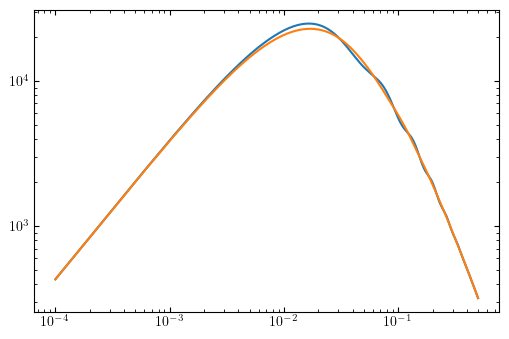

In [6]:
kh = np.linspace(0.0001, .5, num=1000)
plt.loglog(kh, [cm.matter_power_spectrum(x) for x in kh])
plt.loglog(kh, [cm.matter_power_spectrum_no_wiggle(x) for x in kh])

<ipython-input-94-815fc7d2d594>:5: UserWarning: Class did not read input parameter(s): Omega_m
  engine = CLASS.ClassEngine({'H0':70, 'Omega_m':0.31})
/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


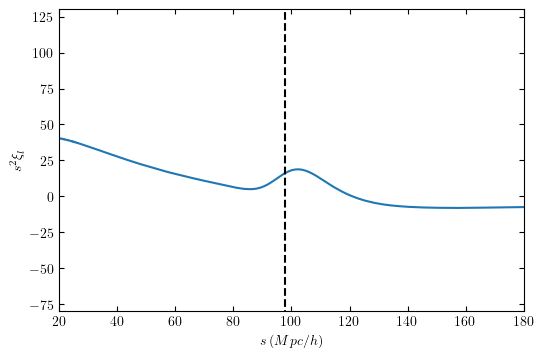

In [94]:
import hankl
import classylss
import classylss.binding as CLASS

engine = CLASS.ClassEngine({'H0':70, 'Omega_m':0.31})
bg = CLASS.Background(engine)
cosmo = CLASS.ClassEngine({'output': 'dTk vTk mPk', 'non linear': 'halofit', 'P_k_max_h/Mpc' : 20., "z_max_pk" : 100.0})
sp = CLASS.Spectra(cosmo)
tm = CLASS.Thermo(cosmo)

k = np.logspace(-4, 1, 2**10)
pk = sp.get_pklin(k=k, z=0.)

s, xi = hankl.P2xi(k, pk, l=0)

plt.plot(s, xi*s**2)
plt.xlim(20,180)
plt.plot([tm.rs_rec, tm.rs_rec], [-100, 300], 'k--')
plt.ylim(-80,130)
plt.xlabel(r'$s\: (Mpc/h)$')
plt.ylabel(r'$s^{2} \xi_{l}$')
plt.show()

/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yanlong/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, 

Text(0.5, 0, '$r\\,[h^{-1}{\\rm Mpc}]$')

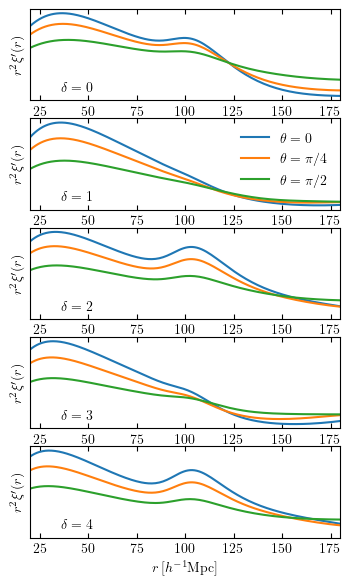

In [124]:
def bis(k1, delta, theta):
    k1, k2, k3 = gs.k_tf(k1, delta*np.pi/tm.rs_rec, theta)
    p1, p2, p3 = sp.get_pklin(k1, 0), sp.get_pklin(k2, 0), sp.get_pklin(k3, 0)
    c1, c2, c3 = gs.cost(k1, k2, k3), gs.cost(k2, k3, k1), gs.cost(k3, k1, k2)
    f1, f2, f3 = gs.f_kernal(k1, k2, c1), gs.f_kernal(k2, k3, c2), gs.f_kernal(k3, k1, c3)
    return 2*(f1*p1*p2+f2*p2*p3+f3*p3*p1)

k = np.logspace(-4, 1, 2**10)

fig, axs = plt.subplots(5, 1, figsize=(4, 7))

for d in [0, 1, 2, 3, 4]:
    ax = axs[d]
    for t, lb in zip(np.array([0, .25, .5])*np.pi, [r'$\theta=0$', r'$\theta=\pi/4$', r'$\theta=\pi/2$']):
        b = [bis(x, d, t) for x in k]
        s, xi = hankl.P2xi(k, b, l=0)
        ax.plot(s, xi*s**2, label=lb)
    ax.set_xlim(20,180)
    ax.annotate(r'$\delta=%d$'%d, (0.1, 0.1), xycoords='axes fraction', ha='left')
#plt.ylim(10,1000)
axs[1].legend(ncol=1, frameon=False)
for ax in axs:
    ax.set_yticks([])
    ax.set_ylabel(r"$r^2\xi'(r)$")
axs[-1].set_xlabel(r'$r\,[h^{-1}{\rm Mpc}]$')

In [14]:
anu = 7/8 *(4/11)**(4/3)
anu = 1/anu
def set_omch2(nnu, ombh2, omch2):
    return (anu+nnu)/(anu+3.046)*(ombh2+omch2)-ombh2

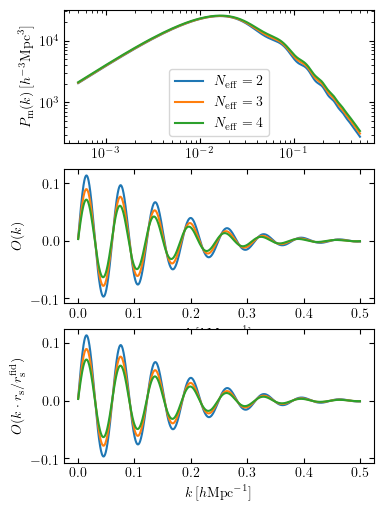

In [106]:
fig, axs = plt.subplots(3, 1, figsize=(4, 6))

kh = np.linspace(0.0005, .5, num=1000)

p = {'nnu':{'value':3},
     'ombh2': {'value': 0.0223, 'stdev': 0.00015, 'h': 0.0008},
     'omch2': {'value': 0.1188, 'stdev': 0.0012, 'h': 0.001},}
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3

for nnu in [2, 3, 4]:
    p['nnu']['value'] = nnu
    p['omch2']['value'] = set_omch2(nnu, p0['ombh2']['value'], p0['omch2']['value'])
    cm = gc.camb_cosmology(p, p0)
    alpha = cm.alpha
    axs[0].loglog(kh, [cm.matter_power_spectrum(x) for x in kh], label=r'$N_{\rm eff}=%.0f$'%nnu)
    axs[0].set_ylabel(r'$P_{\rm m}(k)\,[h^{-3}{\rm Mpc}^3]$')
    axs[0].legend()
    
    axs[1].plot(kh, [cm.oscillation_part(x) for x in kh])
    axs[1].set_ylabel(r'$O(k)$')
    axs[1].set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$')
    
    axs[2].plot(kh, [cm.oscillation_part(x*alpha) for x in kh])
    axs[2].set_ylabel(r'$O(k\cdot r_{\rm s}/r_{\rm s}^{\rm fid})$')
    axs[2].set_xlabel(r'$k\,[h{\rm Mpc}^{-1}]$')
    
plt.savefig('neutrino_effect_ps.pdf', bbox_inches='tight')

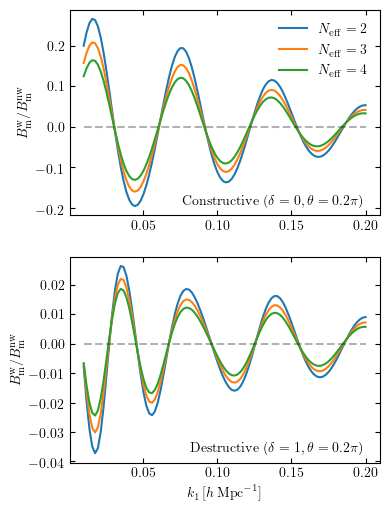

In [86]:
p = {'nnu':{'value':3},
     'ombh2': {'value': 0.0223, 'stdev': 0.00015, 'h': 0.0008},
     'omch2': {'value': 0.1188, 'stdev': 0.0012, 'h': 0.001},}
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3


fig, axs = plt.subplots(2, 1, figsize=(4, 6))
ks = np.linspace(0.01, 0.2, num=100)
for nnu in [2, 3, 4]:
    p['nnu']['value'] = nnu
    p['omch2']['value'] = set_omch2(nnu, p0['ombh2']['value'], p0['omch2']['value'])
    svy = gs.survey(p, p0, prepare_derivatives=False)
    alpha = svy.camb_cosmology.alpha
    svy.update_survey_setups()
    for i in range(2):
        ax = axs[i]
        bs = [svy.bispectrum((x*alpha, svy.pisf*i, 0.2*np.pi), matter_only=True, coordinate='child18', damp=False)\
          /svy.bispectrum((x*alpha, svy.pisf*i, 0.2*np.pi), matter_only=True, coordinate='child18', damp=False, no_wiggle=True)-1.\
          for x in ks]
        if i==0:
            label = r'$N_{\rm eff}=%d$'%nnu
        else:
            label = None
        ax.plot(ks, bs, label = label)
        if i==0:
            ax.legend(frameon=False)
        ax.set_ylabel(r'$B^{\rm w}_{\rm m}/B^{\rm nw}_{\rm m}$')
        
axs[0].annotate(r'Constructive ($\delta=0, \theta=0.2\pi$)', (0.95, 0.05), xycoords='axes fraction', ha='right')
axs[1].annotate(r'Destructive ($\delta=1, \theta=0.2\pi$)', (0.95, 0.05), xycoords='axes fraction', ha='right')
axs[1].set_xlabel(r'$k_1\,[h\,{\rm Mpc}^{-1}]$')

for ax in axs:
    ax.plot([0.01, 0.2], [0, 0], 'k--', alpha=.3)

plt.savefig('plots/nnu-bispectrum-interference.pdf', bbox_inches='tight')
plt.show()

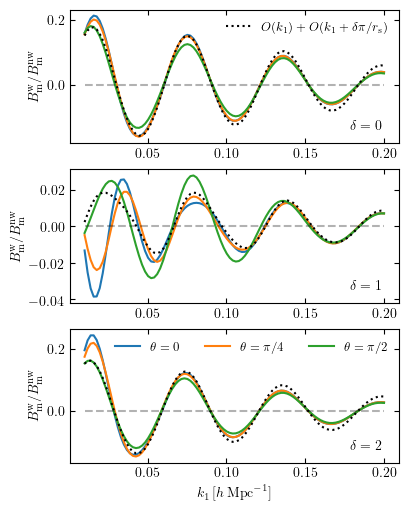

In [128]:
p = {'nnu':{'value':3},
     'ombh2': {'value': 0.0223, 'stdev': 0.00015, 'h': 0.0008},
     'omch2': {'value': 0.1188, 'stdev': 0.0012, 'h': 0.001},}
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3
matplotlib.rcParams['ytick.right'] = True


fig, axs = plt.subplots(3, 1, figsize=(4.25, 6))
ks = np.linspace(0.01, 0.2, num=100)
for nnu in [3.046]:
    p['nnu']['value'] = nnu
    p['omch2']['value'] = set_omch2(nnu, p0['ombh2']['value'], p0['omch2']['value'])
    svy = gs.survey(p, p0, prepare_derivatives=False)
    svy.update_survey_setups()
    for i in range(3):
        for theta, lb in zip([0.001, 0.25*np.pi, 0.5*np.pi], [r'$\theta=0$', r'$\theta=\pi/4$', r'$\theta=\pi/2$']):
            ax = axs[i]
            bs = [svy.bispectrum((x, svy.pisf*i, theta), matter_only=True, coordinate='child18', damp=False)\
              /svy.bispectrum((x, svy.pisf*i, theta), matter_only=True, coordinate='child18', damp=False, no_wiggle=True)-1.\
              for x in ks]
            if i==2:
                ax.plot(ks, bs, label=lb)
            else:
                ax.plot(ks, bs)
        os = [svy.camb_cosmology.oscillation_part(x)+svy.camb_cosmology.oscillation_part(x+svy.pisf*i) for x in ks]
        if i==0:
            ax.plot(ks, os, c='k', ls=':', label=r'$O(k_1)+O(k_1+\delta\pi/r_{\rm s})$')
        else:
            ax.plot(ks, os, c='k', ls=':')
        ax.annotate(r'$\delta=%d$'%i, (0.95, 0.1), xycoords='axes fraction', ha='right')

for ax in axs:
    ax.plot([0.01, 0.2], [0, 0], 'k--', alpha=.3)
    ax.set_ylabel(r'$B^{\rm w}_{\rm m}/B_{\rm m}^{\rm nw}$')
axs[-1].set_xlabel(r'$k_1\,[h\,{\rm Mpc}^{-1}]$')
axs[0].legend(frameon=False, prop={'size': 9})
axs[-1].legend(frameon=False, ncol=3, prop={'size': 9},)

plt.savefig('plots/bispectrum-wiggles.pdf', bbox_inches='tight')
plt.show()

In [4]:
%timeit cm.matter_power_spectrum_no_wiggle(0.5)

95.6 ns ± 0.938 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [5]:
%timeit cm.matter_power_spectrum(0.5)

93.4 ns ± 0.22 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [6]:
cm.matter_power_spectrum.cache_info()

CacheInfo(hits=81111110, misses=1000001, maxsize=None, currsize=1000001)

In [7]:
%timeit cm.oscillation_part(0.5)

95 ns ± 0.33 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [8]:
%timeit cm.q_isotropic(0.5)

93.1 ns ± 0.151 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


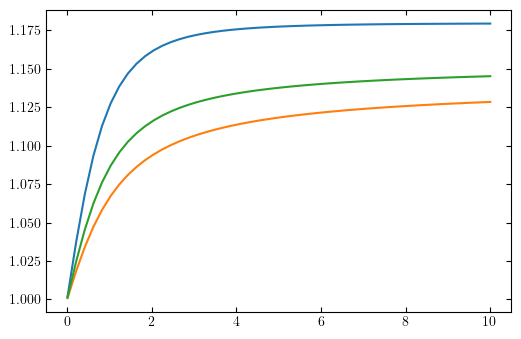

In [43]:
p['nnu']['value'] = 4
p0 = copy.deepcopy(p)
p0['nnu']['value'] = 3
cm = gc.camb_cosmology(p, p0)
for q in cm.get_ap_factors():
    zs = np.linspace(0.01, 10)
    plt.plot(zs, [q(x) for x in zs])

In [31]:
pp = cm.power_spectrum_derivative_parts_factory({'nnu':{'value':2}}, {'nnu':{'value':4}}, 1)

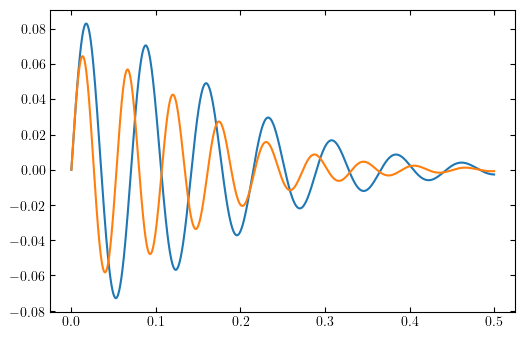

In [32]:
kh = np.linspace(0.0001, .5, num=1000)
for key in ['plus', 'minus']:
    plt.plot(kh, [pp[key]['oscillation_part'](x) for x in kh])

In [18]:
cm.prepare_power_spectrum_derivative_parts(['ombh2', 'nnu'])

In [20]:
cm.power_spectrum_derivative_parts

{'ombh2': {'plus': {'matter_power_spectrum': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'matter_power_spectrum_no_wiggle': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'oscillation_part': <function galaxy_correlations.camb_cosmology.get_power_spectrum.<locals>.<lambda>(x)>,
   'q_parallel': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>,
   'q_vertical': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>,
   'q_isotropic': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>},
  'minus': {'matter_power_spectrum': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'matter_power_spectrum_no_wiggle': <function dewiggle.dewiggle.<locals>.<lambda>(x)>,
   'oscillation_part': <function galaxy_correlations.camb_cosmology.get_power_spectrum.<locals>.<lambda>(x)>,
   'q_parallel': <function galaxy_correlations.camb_cosmology.get_ap_factors.<locals>.<lambda>(x)>,
   'q_vertical':

## Debug galaxy_survey PS

In [1]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)
import fisher_matrix as fm
reload(fm)

<module 'fisher_matrix' from 'C:\\Users\\yanlo\\Dropbox\\galaxy_survey\\fisher_matrix.py'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

In [3]:
cp = {'nnu':{'value':3.046}}
fcp = {'nnu':{'value':3.046}}

In [4]:
#svy = gs.survey(cosmological_parameters=cp, fiducial_cosmological_parameters=fcp)
svy = gs.survey()
svy.update_survey_setups()

[[-6.58099546e+00  6.15705909e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -9.27994231e-02 -4.49926456e+02 -1.22493407e-01]
 [-6.03060993e+00  5.63864987e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -8.50695526e-02 -4.20274987e+02 -1.12182538e-01]
 [-5.51233046e+00  5.15050112e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -7.77906564e-02 -3.92353821e+02 -1.02473340e-01]
 [-5.03220375e+00  4.69830533e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -7.10476838e-02 -3.66488692e+02 -9.34791247e-02]
 [-4.59288383e+00  4.28455935e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -6.48779214e-02 -3.42822522e+02 -8.52496203e-02]
 [-4.19449085e+00  3.90937359e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.92830564e-02 -3.21361699e+02 -7.77870676e-02]
 [-3.83543558e+00  3.57124872e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.42407598e-02 -3.02020517e+02 -7.10616716e-02]
 [-3.51310152e+00  3.26771830e+00  0.00000000e+00  0.00000000e+00
   

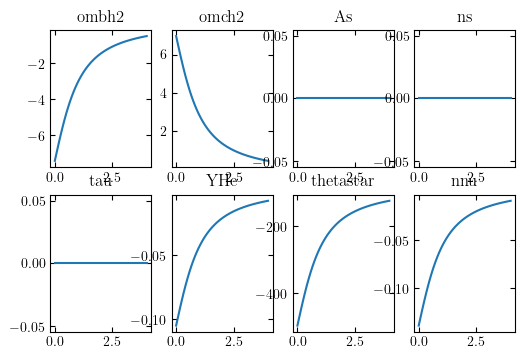

In [6]:
zs = np.linspace(0, 4)

fig, axs = plt.subplots(2, 4)
for key, i in zip(svy.cosmological_parameters_in_fisher, range(8)):
    ax = axs[i//4, i%4]
    dadp = [svy.camb_cosmology.d_alpha_d_parameter(x, key) for x in zs]
    ax.plot(zs, dadp)
    ax.set_title(key)
    
svy.prepare_alpha_transfer_matrix(alpha_redshift_dependence=True)
print(svy.alpha_transfer_matrix)
print(svy.alpha_transfer_matrix_entries)

In [61]:
svy0 = gs.survey(cosmological_parameters=cp, fiducial_cosmological_parameters=fcp, cosmological_parameters_in_fisher=[])
svy0.update_survey_setups()

In [6]:
%timeit svy.integrand_bs((.1,.1,.1,0,0),0)
#%timeit svy.integrand_ps(0.4, 0, 0)

1.27 ms ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


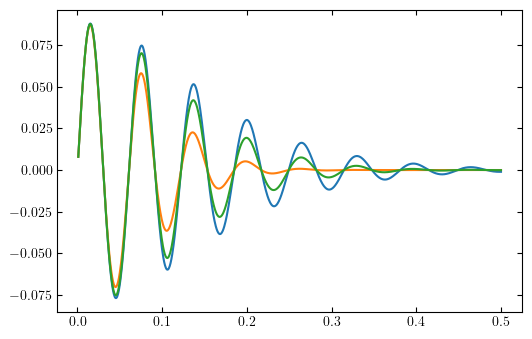

In [7]:
kh = np.linspace(0.001, .5, num=1000)
plt.plot(kh, [svy.oscillation_part(x, damp=False) for x in kh])
plt.plot(kh, [svy.oscillation_part(x, damp=True) for x in kh])
plt.plot(kh, [svy.oscillation_part(x, damp=True, reconstruction=True) for x in kh])

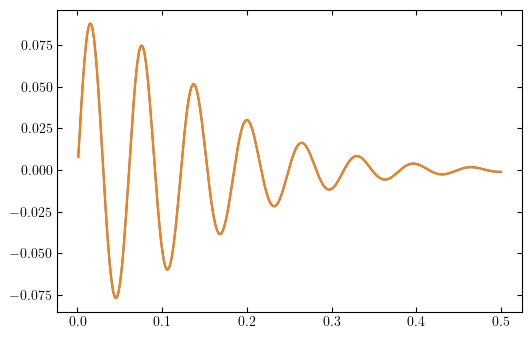

In [8]:
kh = np.linspace(0.001, .5, num=1000)
plt.plot(kh, [svy0.oscillation_part(x) for x in kh])
plt.plot(kh, [svy.oscillation_part(x, fix_rstar=True, ap_effect=False) for x in kh])

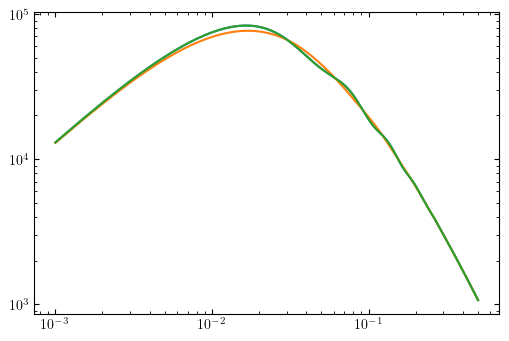

In [9]:
kh = np.linspace(0.001, .5, num=1000)
mu, z = 1, 1
plt.loglog(kh, [svy.power_spectrum(x, mu, z) for x in kh])
plt.loglog(kh, [svy.power_spectrum(x, mu, z, no_wiggle=True) for x in kh])
plt.loglog(kh, [svy.power_spectrum(x, mu, z, debug=True, rsd=True, bias=True, noise=True, damp=True, ap_effect=True, reconstruction=True) for x in kh])

2.1476862055383164

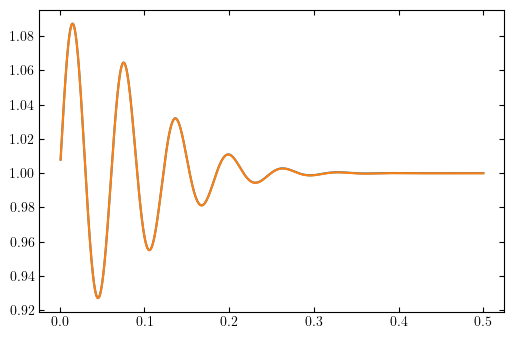

In [10]:
kh = np.linspace(0.001, .5, num=1000)
mu, z = 1, 0
plt.plot(kh, [svy.power_spectrum(x, mu, z)/svy.power_spectrum(x, mu, z, no_wiggle=True) for x in kh])
plt.plot(kh, [svy.power_spectrum(x, mu, z, matter_only=True, external_ps_parts=(lambda x: 1.0, svy.camb_cosmology.oscillation_part, 
            svy.camb_cosmology.q_parallel, svy.camb_cosmology.q_vertical, svy.camb_cosmology.q_isotropic)) for x in kh])

svy.rsd_factor_z1(z, mu, rsd=True, bias=True)**2

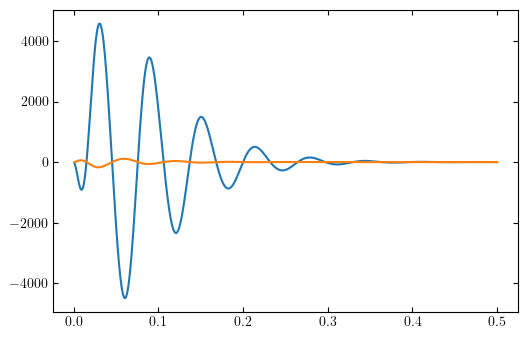

In [11]:
kh = np.linspace(0.001, .5, num=1000)
dos = np.array([svy.power_spectrum_derivative_analytical(x) for x in kh])
plt.plot(kh, dos[:,0])
plt.plot(kh, dos[:,1])

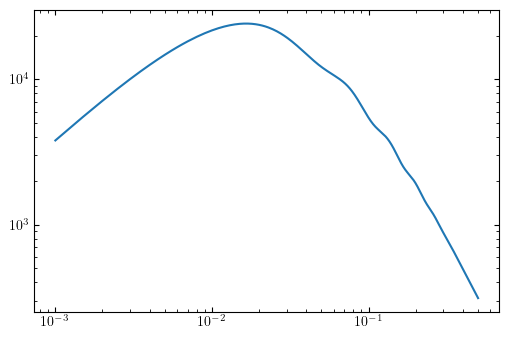

In [12]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.power_spectrum_derivative_bias(x)[0] for x in kh])
plt.loglog(kh, dps)

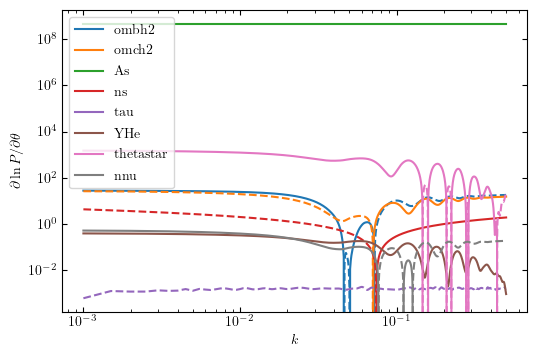

In [13]:
kh = np.linspace(0.001, .5, num=1000)
z=0
dps = np.array([np.array(svy.power_spectrum_derivative_cosmological_parameters(x, z=z))/svy.power_spectrum(x, z=z) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.loglog(kh, dps[:,i], label=l)
    plt.loglog(kh, -dps[:,i], c=pl[0].get_color(), ls='--')
    
plt.ylabel(r'$\partial \ln P/\partial \theta$')
plt.xlabel('$k$')
plt.legend()

0.19403084266200743

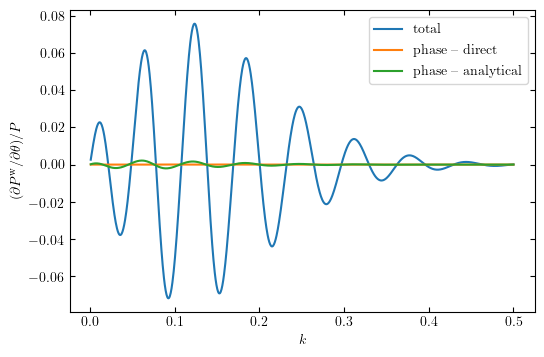

In [73]:
kh = np.linspace(0.001, .5, num=1000)
z=2
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, wiggle_only=True)\
                /svy.power_spectrum(x, z=z, no_wiggle=True) for x in kh])

pl = plt.plot(kh, dps[:,-1], label='total')
    
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, wiggle_only=False, phase_only=True)\
                /svy.power_spectrum(x, z=z, no_wiggle=True) for x in kh])

pl = plt.plot(kh, dps[:,-1], label='phase -- direct')


dps = np.array([svy.power_spectrum_derivative_analytical(x)\
                /svy.power_spectrum(x, z=z, no_wiggle=True) for x in kh])

dbdn = (df.n2b(3.047)-df.n2b(3.046))/0.001
pl = plt.plot(kh, dps[:,-1]*dbdn, label='phase -- analytical')

plt.ylabel(r'$(\partial P^{\rm w}/\partial \theta)/P$')
plt.xlabel('$k$')
plt.legend()
dbdn

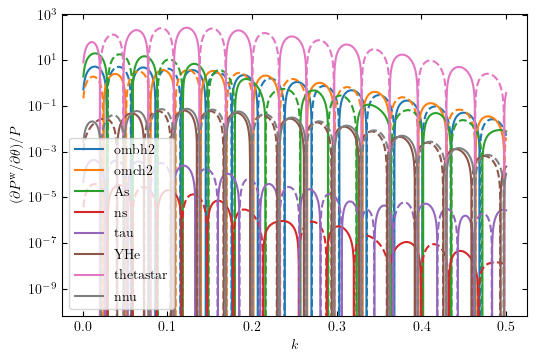

In [15]:
kh = np.linspace(0.001, .5, num=1000)
z=0
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, wiggle_only=True)/svy.power_spectrum(x, z=z) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.semilogy(kh, dps[:,i], label=l)
    plt.plot(kh, -dps[:,i], c=pl[0].get_color(), ls='--')

plt.ylabel(r'$(\partial P^{\rm w}/\partial \theta)/P$')
plt.xlabel('$k$')
plt.legend()

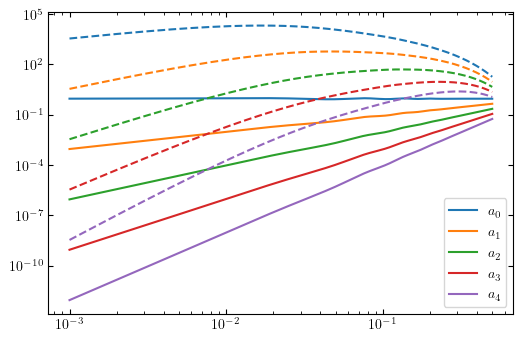

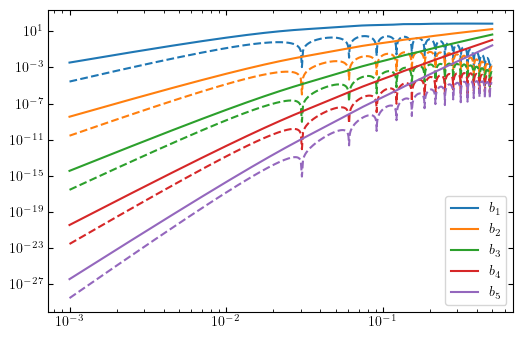

In [16]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.power_spectrum_derivative_polynomial(x) for x in kh])
dpws = np.array([svy.power_spectrum_derivative_polynomial(x, wiggle_only=True) for x in kh])
a = svy.polynomial_parameters['a']
b = svy.polynomial_parameters['b']
for i, l in zip(range(len(a)), a):
    pl = plt.loglog(kh, dps[:,i], label='$a_{%d}$'%l)
    plt.loglog(kh, dpws[:,i], ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

for i, l in zip(range(len(a), len(a)+len(b)), b):
    pl = plt.loglog(kh, dps[:,i], label='$b_{%d}$'%l)
    plt.loglog(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

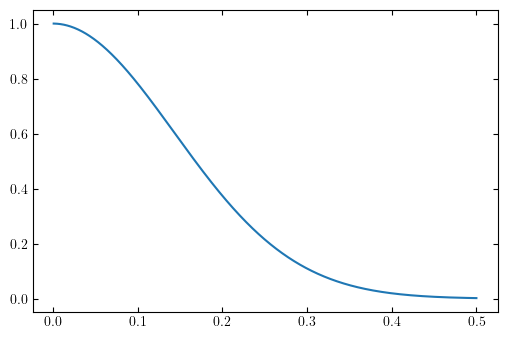

In [17]:
kh = np.linspace(0.001, .5, num=1000)
mu, z = 1, 2
dps = np.array([svy.power_spectrum(x, mu, z, no_wiggle=False, matter_only=False) for x in kh])
dpnws = np.array([svy.power_spectrum(x, mu, z, no_wiggle=True, matter_only=False) for x in kh])
damps = np.array([svy.damping_factor(x, mu, z, damp=True, reconstruction=True) for x in kh])
plt.plot(kh, damps)

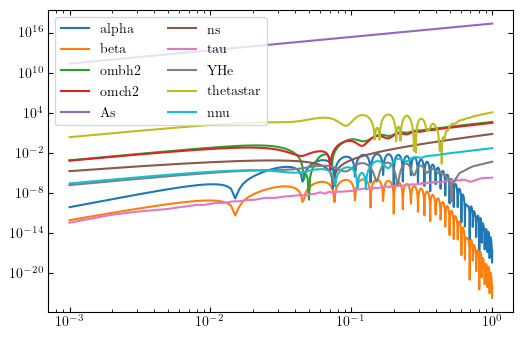

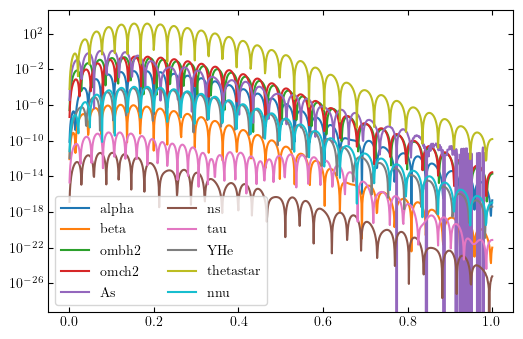

In [18]:
kh = np.linspace(0.001, 1, num=1000)

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_ps(x, 0, 0)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_ps(x, 0, 0, wiggle_only=True)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

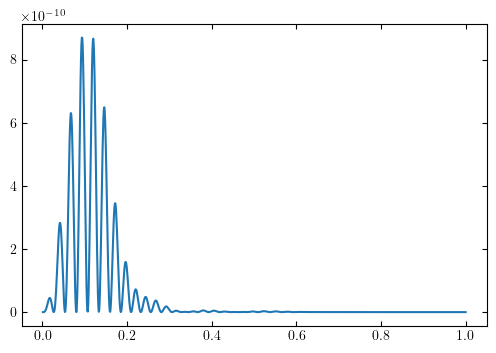

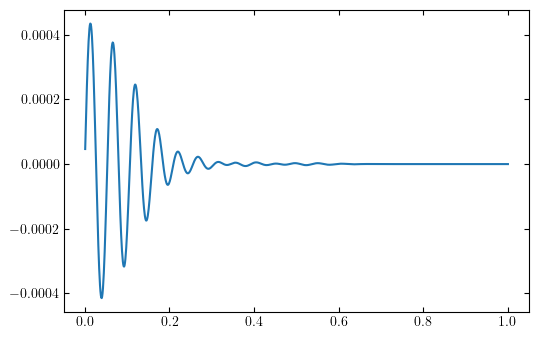

In [34]:
kh = np.linspace(0.001, 1, num=1000)
i = 6
dp = [svy.integrand_ps(x, 0, 0, wiggle_only=True)[i, i] for x in kh]
pl = plt.plot(kh, dp)
plt.show()

kh = np.linspace(0.001, 1, num=1000)
z = 0
dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, z=z, wiggle_only=True)/svy.power_spectrum(x, z=z) for x in kh])
pl = plt.plot(kh, dps[:,i-2], label=l)

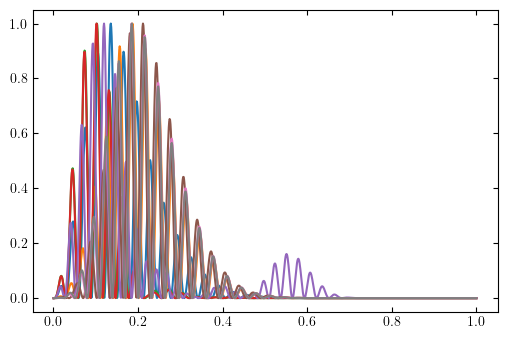

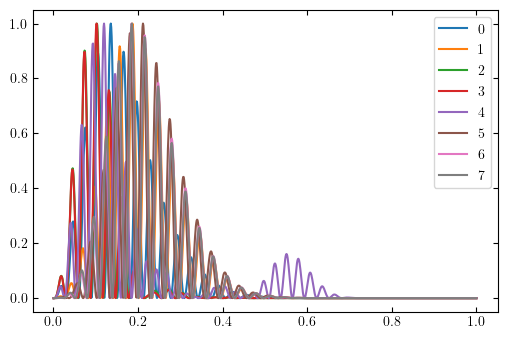

In [32]:
kh = np.linspace(0.001, 1, num=1000)
svy.update_survey_setups(ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fisher', 'polynomial_in_fisher', 'ap_effect', 'shot_noise', 'reconstruction'])

mu, z = 0, 1

for i in range(2, 10):
    dp = np.array([svy.integrand_ps(x, mu, z, wiggle_only=True)[i, i] for x in kh])
    pl = plt.plot(kh, dp/dp.max())
plt.show()

for j in range(8):
    dps = np.array([svy.power_spectrum_derivative_cosmological_parameters(x, mu, z, wiggle_only=True) for x in kh])
    ps = np.array([svy.power_spectrum(x, mu, z) for x in kh])
    ts = dps[:,j]**2/ps**2*kh**2
    plt.plot(kh, ts/ts.max(), label='%d'%j)
plt.legend()
plt.show()

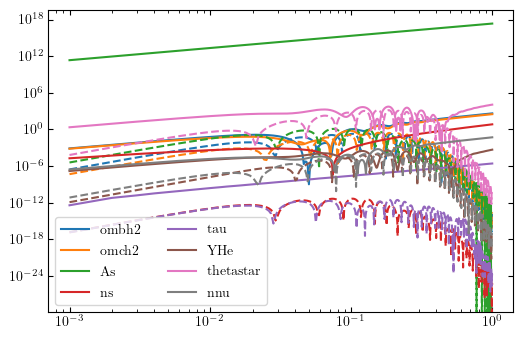

In [20]:
kh = np.linspace(0.001, 1, num=1000)

for i, l in zip(range(2, 10), svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_ps(x, 0, 0)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
    dp = [svy.integrand_ps(x, 0, 0, wiggle_only=True)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, ls='--', c=pl[0].get_color())    
plt.legend(ncol=2)
plt.show()

In [21]:
for x in [False, True]:
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x)
    print(fs.constraints()[1]['nnu'], fs.constraints()[1]['beta'])

0.4661712183339122 0.1790021648484712
11.658901557228004 0.39468065778827627


In [22]:
for x in [False, True]:
    svy.update_survey_setups(ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fishe', 'polynomial_in_fishe', 'ap_effect', 'shot_noise', 'reconstruction'])
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x)
    print(fs.constraints()[1]['nnu'], fs.constraints()[1]['beta'])

0.2680052713589669 0.13684260754913788
3.5390286235215127 0.23771712563501715


In [72]:
def sb2sn(x):
    return 1/0.194057*x
def sn2sb(y):
    return 0.194057*y

In [17]:
import h5py
for x in [False, True]:
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x)
    with h5py.File('planck_cmb_fisher.hdf5', 'r') as cf:
        cmb_fisher = fm.read_hdf5(cf)
    sb = fs.slice(['nnu', 'thetastar'], exclude=True).merge(cmb_fisher).constraints()[1]['beta']
    print(sb, sb2sn(sb))

0.009954393127613077 0.05129623320783624
0.01664502210572712 0.08577388141487872


In [18]:
for x in [False, True]:
    svy.update_survey_setups(ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fisher', 'polynomial_in_fisher', 'ap_effect', 'shot_noise', 'reconstruction'])
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x).slice(['alpha', 'beta'], exclude=True)
    fs.matrix = fs.matrix
    with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
        cmb_fisher = fm.read_hdf5(cf)
    sn = fs.merge(cmb_fisher).slice(['YHe'], exclude=True).constraints()[1]['nnu']
    print(sn)

0.014871077266374596
0.03451123372070868


In [63]:
ndesi = np.loadtxt('desi-density.txt')
ndesi[:,1]/=1e3
sky_deg = 4*np.pi*(180/np.pi)**2
desi_geo = {
    'f_sky': 14000/sky_deg,
    'ng_z_list': ndesi,
    'dz': 0.1,
    'Sigma_0': 16.6,
    'b_0': 0.95,
    'survey_type':'spectroscopic',
    'sigma8_0': 0.9,
}

In [64]:
svy.update_survey_setups(desi_geo, polynomial_parameters={'a': [], 'b': [1, ]})

In [50]:
for x in [True, False]:
    fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x, regions=[{'k_min': 0.01,'k_max': 0.5,'mu_min': -1.0,'mu_max': 1.0}])
    fs = fs.slice(['alpha', 'beta'], exclude=True)
    with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
        cmb_fisher = fm.read_hdf5(cf)
    sn = fs.merge(cmb_fisher).slice(['YHe'], exclude=True).constraints()[1]['nnu']
    print(sn)

0.09576190122613
0.03967311168932633


In [35]:
import h5py
import defaults as df

dfs = df.defaults()
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid,]
#surveys = [dfs.boss, dfs.desi]

with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)

ks = np.linspace(0.011, 0.3, num=41)

with h5py.File("ps_kamx_dependence.hdf5", "w") as f:
    f.create_dataset('kmaxs', data=ks)
    for survey in surveys:
        key_svy = survey['short_name']
        print(key_svy)
        if key_svy not in list(f.keys()):
            group_svy = f.create_group(key_svy)
        else:
            group_svy = f[key_svy]
        
        sns = []
        for k in tqdm(ks):
            temp = []
            for x in [False, True]:
                if x:
                    pp = {'a': [0,1,2,3,4], 'b' :[1,2,3]}
                else:
                    pp = {'a': [], 'b' :[1]}
                svy.update_survey_setups(survey_geometrics=survey, polynomial_parameters=pp,
                                        ingredients=['RSD', 'damping', 'galactic_bias', 'bias_in_fisher', 'polynomial_in_fisher', 'ap_effect', 'shot_noise'],
                                        )
                fs = svy.get_power_spectrum_fisher_matrix(wiggle_only=x, 
                                                          div_k = int(max((k-0.01)//0.005, 2)),
                                                          div_mu = 20,
                                                          regions=[{'k_min': 0.01,'k_max': k,'mu_min': -1.0,'mu_max': 1.0}])
                fs = fs.slice(['poly', 'bias'], fuzzy_filter=True, exclude=True)
                sn = fs.merge(cmb_fisher).slice(['YHe', 'alpha', 'beta'], exclude=True).constraints()[1]['nnu']
                temp.append(sn)
                sn = fs.merge(cmb_fisher).slice(['alpha', 'beta'], exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        group_svy.create_dataset('sns', data=sns)

boss


  0%|          | 0/41 [00:00<?, ?it/s]

desi


  0%|          | 0/41 [00:00<?, ?it/s]

spherex


  0%|          | 0/41 [00:00<?, ?it/s]

pfs


  0%|          | 0/41 [00:00<?, ?it/s]

roman


  0%|          | 0/41 [00:00<?, ?it/s]

euclid


  0%|          | 0/41 [00:00<?, ?it/s]

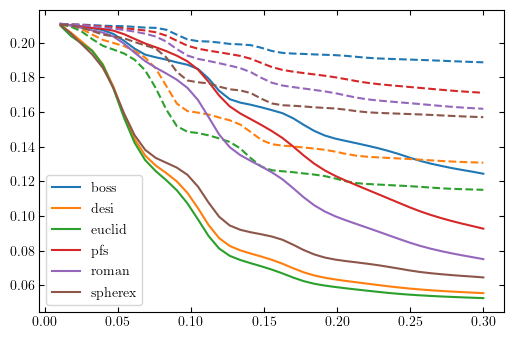

In [36]:
with h5py.File("ps_kamx_dependence.hdf5", 'r') as f:
    kmaxs = f['kmaxs']
    for svy_key in f.keys():
        if svy_key == 'cvl' or svy_key =='kmaxs':
            continue
        sns = f[svy_key]['sns'][()]
        #print(sns)
        pl = plt.plot(kmaxs, sns[:,0], label=svy_key)
        plt.plot(kmaxs, sns[:,2], ls='--', c=pl[0].get_color())
    plt.legend()
    plt.show()

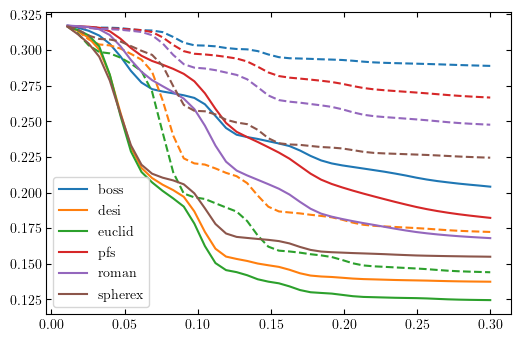

In [37]:
with h5py.File("ps_kamx_dependence.hdf5", 'r') as f:
    kmaxs = f['kmaxs']
    for svy_key in f.keys():
        if svy_key == 'kmaxs' or svy_key == 'cvl':
            continue
        sns = f[svy_key]['sns'][()]
        pl = plt.plot(kmaxs, sns[:,1], label=svy_key)
        plt.plot(kmaxs, sns[:,3], ls='--', c=pl[0].get_color())
    plt.legend()
    plt.show()

## Debug galaxy_survey BS

In [4]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

import fisher_matrix as fm

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

In [5]:
svy = gs.survey()

In [4]:
svy.update_survey_setups()

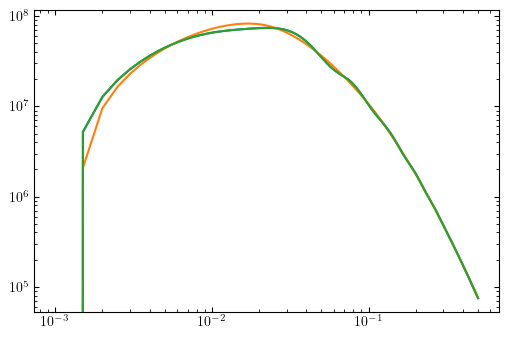

In [5]:
kh = np.linspace(0.001, .5, num=1000)
plt.loglog(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18') for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', no_wiggle=True) for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', reconstruction=True) for x in kh])

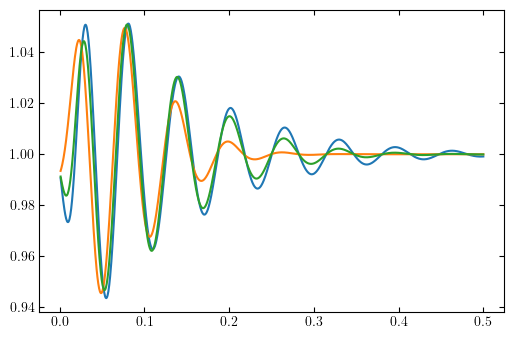

In [6]:
kh = np.linspace(0.001, .5, num=1000)
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True)
              /svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, no_wiggle=True) for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, damp=True, reconstruction=False)
              /svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, no_wiggle=True) for x in kh])
plt.plot(kh, [svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, damp=True, reconstruction=True)
              /svy.bispectrum((x, 0.1, 1), coordinate='child18', debug=True, no_wiggle=True) for x in kh])

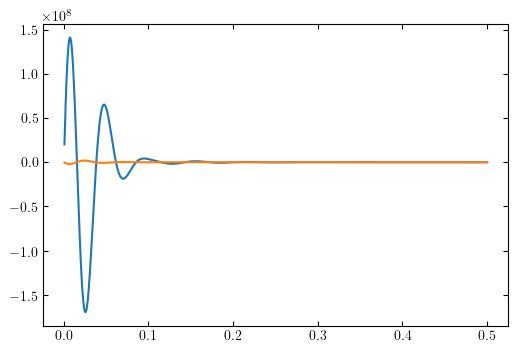

In [7]:
kh = np.linspace(0.001, .5, num=1000)
dos = np.array([svy.bispectrum_derivative_analytical((x, 0.1, 1), coordinate='child18',) for x in kh])
plt.plot(kh, dos[:,0])
plt.plot(kh, dos[:,1])

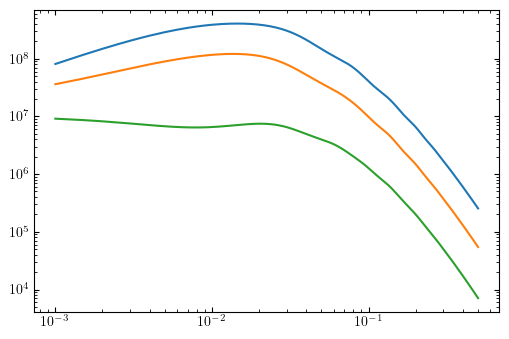

In [8]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_bias((x, 0.1, 1), coordinate='child18',) for x in kh])
plt.loglog(kh, dps[:,0])
plt.loglog(kh, dps[:,1])
plt.loglog(kh, dps[:,2])

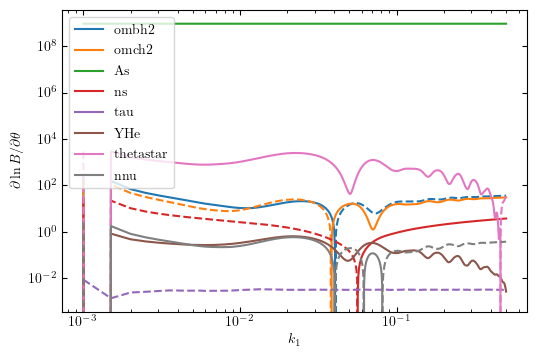

In [9]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_cosmological_parameters((x, 0.1, 1), coordinate='child18',)\
                /svy.bispectrum((x, 0.1, 1), coordinate='child18',) for x in kh])
for i, l in zip(range(len(svy.cosmological_parameters_in_fisher)), svy.cosmological_parameters_in_fisher):
    pl = plt.loglog(kh, dps[:,i], label=l)
    plt.loglog(kh, -dps[:,i], c=pl[0].get_color(), ls='--')
    
plt.ylabel(r'$\partial \ln B/\partial \theta$')
plt.xlabel('$k_1$')
plt.legend()

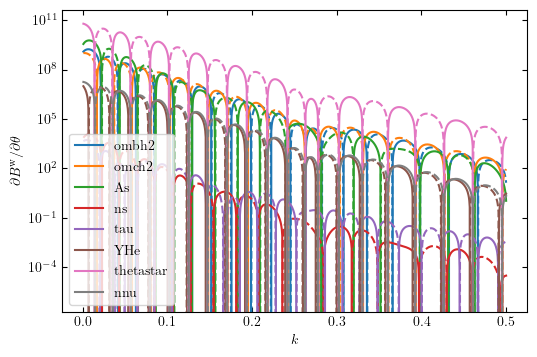

In [10]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_cosmological_parameters((x, svy.pisf*1, np.pi/2), coordinate='child18',
                wiggle_only=True) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.semilogy(kh, dps[:,i], label=l)
    plt.plot(kh, -dps[:,i], c=pl[0].get_color(), ls='--')

plt.ylabel(r'$\partial B^{\rm w}/\partial \theta$')
plt.xlabel('$k$')
plt.legend()

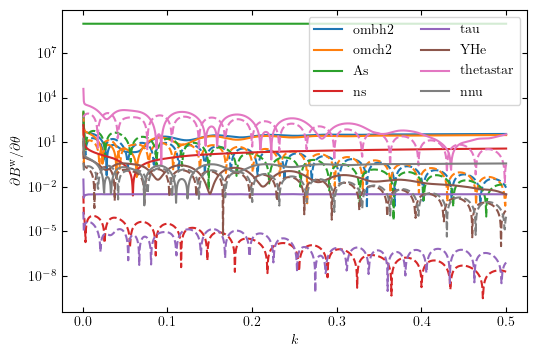

In [11]:
kh = np.linspace(0.001, .5, num=1000)

xx = 2
yy = 0.0001

dps = np.array([svy.bispectrum_derivative_cosmological_parameters((x, svy.pisf*xx, np.pi*yy), coordinate='child18',
                wiggle_only=False)/svy.bispectrum((x, svy.pisf*xx, np.pi*yy), coordinate='child18',) for x in kh])
dpws = np.array([svy.bispectrum_derivative_cosmological_parameters((x, svy.pisf*xx, np.pi*yy), coordinate='child18',
                wiggle_only=True)/svy.bispectrum((x, svy.pisf*xx, np.pi*yy), coordinate='child18',) for x in kh])
for i, l in zip(range(8), svy.cosmological_parameters_in_fisher):
    pl = plt.semilogy(kh, np.abs(dps[:,i]), label=l)
    plt.semilogy(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())

plt.ylabel(r'$\partial B^{\rm w}/\partial \theta$')
plt.xlabel('$k$')
plt.legend(ncol=2)

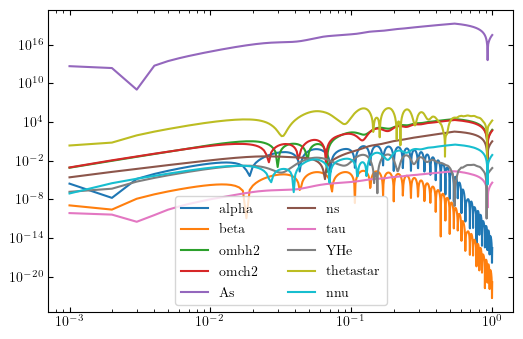

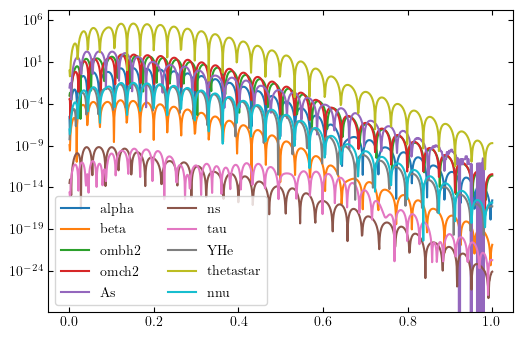

In [12]:
kh = np.linspace(0.001, 1, num=1000)

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=False, k_max_bi=3)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=True, k_max_bi=3)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

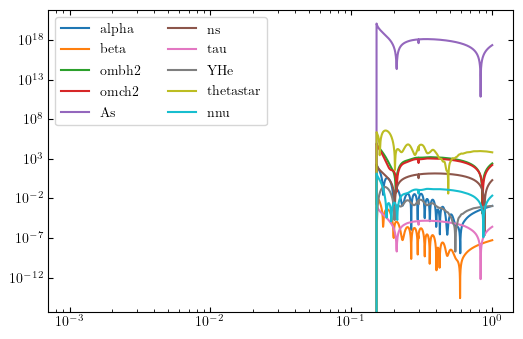

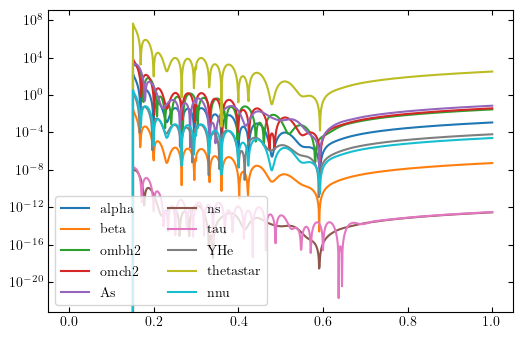

In [13]:
kh = np.linspace(0.001, 1, num=1000)
k1 = 0.01

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, x, .3, 0, 0), 0, coordinate='cartesian',wiggle_only=False, k_max_bi=3)[i, i] for x in kh]
    pl = plt.loglog(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

for i, l in zip(range(0, 10), ['alpha', 'beta']+svy.cosmological_parameters_in_fisher):
    dp = [svy.integrand_bs((x, x, .3, 0, 0), 0, coordinate='cartesian',wiggle_only=True, k_max_bi=3)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp, label=l)    
plt.legend(ncol=2)
plt.show()

<ipython-input-22-06ed6841867d>:13: RuntimeWarning: divide by zero encountered in log10
  db[xx, yy] = np.log10(svy.integrand_bs((X[xx, yy], Y[xx, yy], k3, 0, 0), 0, unique=True, coordinate='cartesian',wiggle_only=True, k_max_bi=k_max)[i, i])


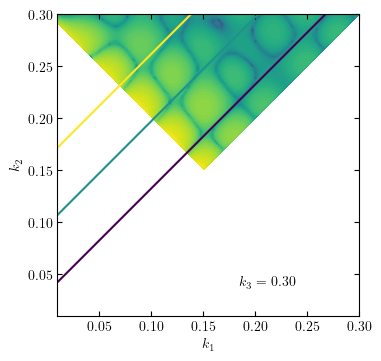

In [22]:
k_max = 0.3
k3 = 0.3
X = np.linspace(0.01, k_max, num=100)
Y = np.linspace(0.01, k_max, num=100)
X, Y = np.meshgrid(X, Y)
i = 9

db = np.zeros(X.shape)
ct = np.zeros(X.shape)
ct2 = np.zeros(X.shape)
for xx in range(len(X)):
    for yy in range(len(Y)):
        db[xx, yy] = np.log10(svy.integrand_bs((X[xx, yy], Y[xx, yy], k3, 0, 0), 0, unique=True, coordinate='cartesian',wiggle_only=True, k_max_bi=k_max)[i, i])
        ct[xx, yy] = (Y[xx, yy]-X[xx, yy])/(svy.pisf)
        ct2[xx, yy] = (Y[xx, yy]+X[xx, yy])/(svy.pisf)
        
fig, ax = plt.subplots()
ax.contourf(X, Y, db, levels=100)
ax.contour(X, Y, ct, levels=[1, 3, 5])
#ax.contour(X, Y, ct2, levels=[9, 11, 13])
ax.set_aspect('equal')
ax.set_xlabel('$k_1$')
ax.set_ylabel('$k_2$')
ax.annotate('$k_3=%.2f$'%k3, (0.6, 0.1), xycoords='axes fraction')
plt.show()

Text(0, 0.5, 'Information')

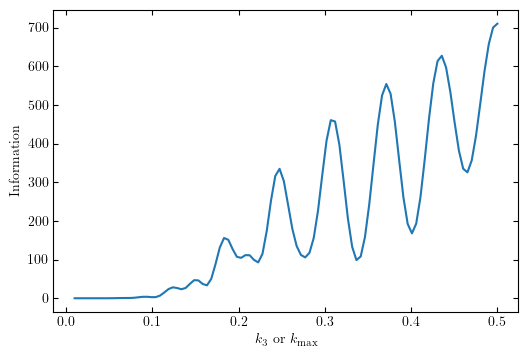

In [16]:
k_max = 0.5

X = np.linspace(0.01, k_max, num=100)
Y = np.linspace(0.01, k_max, num=100)
X, Y = np.meshgrid(X, Y)
i = 9

k3s = np.linspace(0.01, 0.5, num=100)
ints = []
for k3 in k3s:
    db = np.zeros(X.shape)
    for xx in range(len(X)):
        for yy in range(len(Y)):
            db[xx, yy] = (svy.integrand_bs((X[xx, yy], Y[xx, yy], k3, 0, 0), 0, unique=True, coordinate='cartesian',wiggle_only=True, k_max_bi=k_max)[i, i])
    ints.append(np.sum(db))

plt.plot(k3s, ints)
plt.xlabel(r'$k_3$ or $k_{\rm max}$')
plt.ylabel('Information')

No handles with labels found to put in legend.


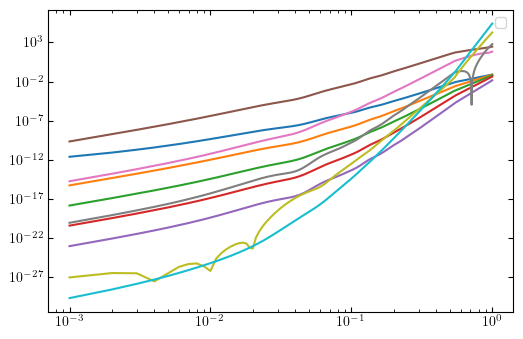

No handles with labels found to put in legend.


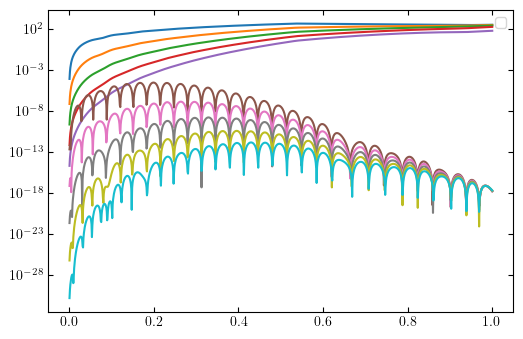

In [16]:
kh = np.linspace(0.001, 1, num=1000)

for i in range(13, 23):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=False, k_max_bi=3)[i, i] for x in kh]
    pl = plt.loglog(kh, dp)    
plt.legend(ncol=2)
plt.show()

for i in range(13, 23):
    dp = [svy.integrand_bs((x, svy.pisf*2, 1, 0, 0), 0, coordinate='child18',wiggle_only=True, k_max_bi=3)[i, i] for x in kh]
    pl = plt.semilogy(kh, dp)    
plt.legend(ncol=2)
plt.show()

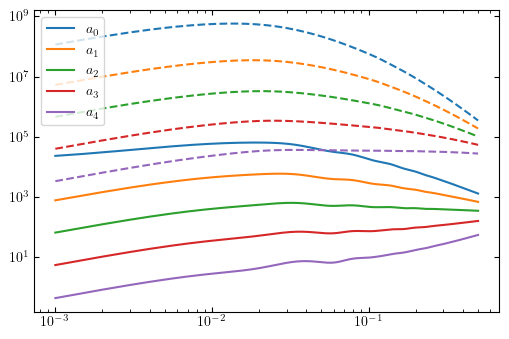

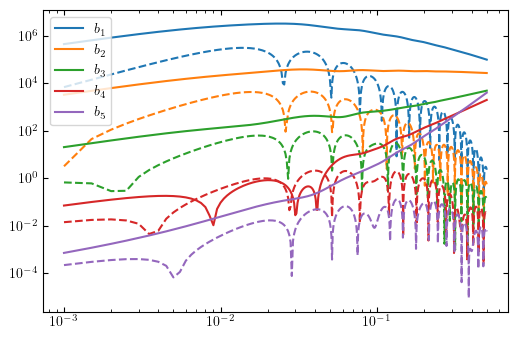

In [17]:
kh = np.linspace(0.001, .5, num=1000)
dps = np.array([svy.bispectrum_derivative_polynomial((x, 0.1, 1), coordinate='child18') for x in kh])
dpws = np.array([svy.bispectrum_derivative_polynomial((x, 0.1, 1), coordinate='child18',
                                                                  wiggle_only=True) for x in kh])
a = svy.polynomial_parameters['a']
b = svy.polynomial_parameters['b']
for i, l in zip(range(len(a)), a):
    pl = plt.loglog(kh, np.abs(dps[:,i]), label='$a_{%d}$'%l)
    plt.loglog(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

for i, l in zip(range(len(a), len(a)+len(b)), b):
    pl = plt.loglog(kh, np.abs(dps[:,i]), label='$b_{%d}$'%l)
    plt.loglog(kh, np.abs(dpws[:,i]), ls='--', c=pl[0].get_color())
plt.legend()
plt.show()

In [53]:
svy.update_survey_setups(
                         survey_geometrics={'f_sky': 0.5,'N_g': 1e100,'z_min': 0.1,'z_max': 4.0,'dz': 0.1,'Sigma_0': 16.6,'reconstruction_rate': 0.5,'b_0': 0.95,'survey_type':'spectroscopic','sigma8_0': 0.9,},
                         )

In [15]:
%timeit svy.integrand_bs((0.01, 0.1, 1, 0, 0), 0, coordinate='child18')

3.85 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
fs = svy.get_bispectrum_fisher_matrix()

In [76]:
fs.slice(['alpha', 'beta'], exclude=True).constraints()[1]['nnu']

0.20155122937596187

In [77]:
sb2sn(fs.slice(['thetastar', 'nnu'], exclude=True).constraints()[1]['beta'])

0.6704678413092431

In [82]:
import h5py
with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)

Removed no burn in
Removed no burn in


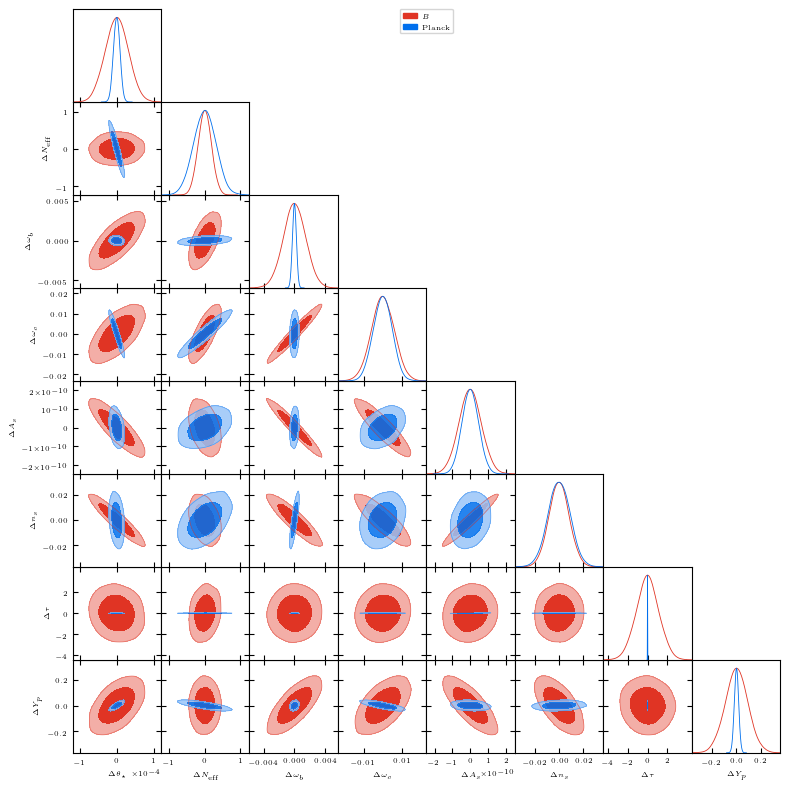

In [96]:
reload(fm)
keys = ['thetastar', 'nnu', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe']
labels =  [r'$\Delta\theta_\star$', r'$\Delta N_{\rm eff}$', r'$\Delta\omega_b$', r'$\Delta\omega_c$', 
           r'$\Delta A_s$', r'$\Delta n_s$', r'$\Delta\tau$', r'$\Delta Y_p$']
fm.triangle_plot([fs, cmb_fisher], keys=keys, fisher_labels=['$B$', 'Planck'], parameter_labels=labels)

In [71]:
with h5py.File('planck_cmb_fisher_original.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)
fs.slice(['alpha', 'beta'], exclude=True).merge(cmb_fisher).constraints()[1]['nnu']

0.05215719970354141

In [75]:
with h5py.File('planck_cmb_fisher.hdf5', 'r') as cf:
    cmb_fisher = fm.read_hdf5(cf)
sb2sn(fs.slice(['thetastar', 'nnu'], exclude=True).merge(cmb_fisher).constraints()[1]['beta'])

0.06406030297083447

## Idealized surveys

In [1]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy
import h5py

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

import fisher_matrix as fm
import defaults as df
reload(df)

<module 'defaults' from 'C:\\Users\\yanlo\\Dropbox\\galaxy_survey\\defaults.py'>

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

In [3]:
svy = gs.survey(cosmological_parameters_in_fisher=[])

In [5]:
sg = {'f_sky': 0.5,'N_g': 1e100,'z_min': 0.1,'z_max': 4.0,'dz': 0.1,'Sigma_0': 16.6,'b_0': 0.95,'survey_type':'spectroscopic','sigma8_0': 0.9,}
ig = ['RSD', 'damping', 'galactic_bias', 'ap_effect', 'shot_noise', 'reconstruction']

In [4]:
with h5py.File("idealized_survey_fisher_matrix.hdf5", "w+") as f:
    for ng in [1e6, 1e7, 1e8, 1e100]:
        sg['N_g'] = ng
        key_svy = 'Ng_%.0e'%ng
        group_svy = f.create_group(key_svy)
        zs = list(np.arange(0.25, 1.8, 0.1))+list(np.arange(2, 4.1, 0.25))
        zs = np.linspace(0.3, 4, num=38)
        print(key_svy, end='\t')
        for z_max in zs:
            sg['z_max'] = z_max
            key_zmax = '%.6f'%z_max
            group_zmax = group_svy.create_group(key_zmax)
            svy.update_survey_setups(survey_geometrics=sg, ingredients=ig)
            print('%.2f'%sg['z_max'], end=' ')
            
            regions=[{'k_min': 0.02,'k_max': 0.5,'mu_min': -1.0,'mu_max': 1.0}]
            fsp = svy.get_power_spectrum_fisher_matrix(regions=regions, wiggle_only=True, div_mu=25, physical_kmin=False)
            fsb = svy.get_bispectrum_fisher_matrix(wiggle_only=True)
            print(fsp.keys)
            
            key_fs = 'P'
            group_fs = group_zmax.create_group(key_fs)
            fsp.write_hdf5(group_fs)
            
            key_fs = 'B'
            group_fs = group_zmax.create_group(key_fs)
            fsb.write_hdf5(group_fs)
    

Ng_1e+06	0.30 ['beta', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin0.20_zmax0.30']
0.40 ['beta', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.10_zmax0.20']
0.50 ['beta', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.10_zmax0.20']
0.60 ['alpha-zmin0.50_zmax0.60', 'beta', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.10_zmax0.20']
0.70 ['alpha-zmin0.50_zmax0.60', 'beta', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.10_zmax0.20']
0.80 ['alpha-zmin0.40_zmax0.50', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'beta', 'alpha-zmin0.70_zmax0.80', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin0.50_zmax0.60']
0.90 ['alpha-zmin0.40_zmax0.50', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.80_zmax0.90', 'beta', 'alpha-zmin0.70_zmax0.80', 'alpha-zmin0.30_zmax0.40', 'a

2.60 ['alpha-zmin2.40_zmax2.50', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin1.80_zmax1.90', 'alpha-zmin0.80_zmax0.90', 'alpha-zmin0.70_zmax0.80', 'beta', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin2.00_zmax2.10', 'alpha-zmin2.50_zmax2.60', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin2.10_zmax2.20', 'alpha-zmin1.40_zmax1.50', 'alpha-zmin1.20_zmax1.30', 'alpha-zmin1.00_zmax1.10', 'alpha-zmin1.10_zmax1.20', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin1.30_zmax1.40', 'alpha-zmin1.60_zmax1.70', 'alpha-zmin1.50_zmax1.60', 'alpha-zmin2.20_zmax2.30', 'alpha-zmin2.30_zmax2.40', 'alpha-zmin1.90_zmax2.00', 'alpha-zmin0.50_zmax0.60']
2.70 ['alpha-zmin2.40_zmax2.50', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin1.80_zmax1.90', 'alpha-zmin1.90_zmax2.00', 'alpha-zmin0.80_zmax0.90', 'alpha-zmin0.70_zmax0.80', 'beta', 'alpha-zmin2.00_zmax2.10', 'alpha-zmin2.50_zmax2.60', 'alpha-zmin0.10_zmax0.20', 

3.70 ['alpha-zmin0.50_zmax0.60', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin2.90_zmax3.00', 'alpha-zmin1.80_zmax1.90', 'alpha-zmin2.70_zmax2.80', 'alpha-zmin0.70_zmax0.80', 'alpha-zmin3.30_zmax3.40', 'alpha-zmin3.40_zmax3.50', 'alpha-zmin3.20_zmax3.30', 'alpha-zmin2.50_zmax2.60', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin1.20_zmax1.30', 'alpha-zmin3.60_zmax3.70', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin3.50_zmax3.60', 'alpha-zmin1.30_zmax1.40', 'alpha-zmin1.60_zmax1.70', 'alpha-zmin1.50_zmax1.60', 'alpha-zmin2.20_zmax2.30', 'alpha-zmin2.80_zmax2.90', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin1.90_zmax2.00', 'alpha-zmin2.40_zmax2.50', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin3.00_zmax3.10', 'beta', 'alpha-zmin2.00_zmax2.10', 'alpha-zmin2.10_zmax2.20', 'alpha-zmin3.10_zmax3.20', 'alpha-zmin1.40_zmax1.50', 'alpha-zmin1.00_zmax1.10', 'alpha-zmin1.10_zmax1.20', 'alpha-zmin2.60_zmax2.70', 'alpha-zmin2.30_zmax2.40', 'alpha-zmin0.80_zmax0.90']
3.80 ['alpha-z

1.90 ['alpha-zmin0.50_zmax0.60', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin1.80_zmax1.90', 'beta', 'alpha-zmin0.70_zmax0.80', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin1.40_zmax1.50', 'alpha-zmin1.20_zmax1.30', 'alpha-zmin1.00_zmax1.10', 'alpha-zmin1.10_zmax1.20', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin1.30_zmax1.40', 'alpha-zmin1.60_zmax1.70', 'alpha-zmin1.50_zmax1.60', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.80_zmax0.90']
2.00 ['alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin1.80_zmax1.90', 'alpha-zmin1.90_zmax2.00', 'alpha-zmin0.80_zmax0.90', 'alpha-zmin0.70_zmax0.80', 'beta', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin1.40_zmax1.50', 'alpha-zmin1.20_zmax1.30', 'alpha-zmin1.00_zmax1.10', 'alpha-zmin1.10_zmax1.20', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin1.30_zmax1.40', 'alpha-zmin1.60_zmax1.70', 'alpha-zmin1.50_zmax1.60', 'alpha-zmin0.30_zmax0.40', 

3.20 ['alpha-zmin2.40_zmax2.50', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin2.90_zmax3.00', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin1.80_zmax1.90', 'alpha-zmin3.00_zmax3.10', 'alpha-zmin2.70_zmax2.80', 'alpha-zmin0.70_zmax0.80', 'beta', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin2.00_zmax2.10', 'alpha-zmin0.80_zmax0.90', 'alpha-zmin2.50_zmax2.60', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin2.10_zmax2.20', 'alpha-zmin3.10_zmax3.20', 'alpha-zmin1.40_zmax1.50', 'alpha-zmin1.20_zmax1.30', 'alpha-zmin1.00_zmax1.10', 'alpha-zmin1.10_zmax1.20', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin2.60_zmax2.70', 'alpha-zmin1.30_zmax1.40', 'alpha-zmin1.60_zmax1.70', 'alpha-zmin1.50_zmax1.60', 'alpha-zmin2.20_zmax2.30', 'alpha-zmin2.80_zmax2.90', 'alpha-zmin2.30_zmax2.40', 'alpha-zmin1.90_zmax2.00', 'alpha-zmin0.50_zmax0.60']
3.30 ['alpha-zmin0.50_zmax0.60', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin2.90_zmax3.00', 'alpha-zmin1.80_zmax1.90', 'alpha-z

Ng_1e+08	0.30 ['beta', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin0.20_zmax0.30']
0.40 ['beta', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.10_zmax0.20']
0.50 ['beta', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.10_zmax0.20']
0.60 ['alpha-zmin0.50_zmax0.60', 'beta', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.10_zmax0.20']
0.70 ['alpha-zmin0.50_zmax0.60', 'beta', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.10_zmax0.20']
0.80 ['alpha-zmin0.40_zmax0.50', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'beta', 'alpha-zmin0.70_zmax0.80', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin0.50_zmax0.60']
0.90 ['alpha-zmin0.40_zmax0.50', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin0.80_zmax0.90', 'beta', 'alpha-zmin0.70_zmax0.80', 'alpha-zmin0.30_zmax0.40', 'a

2.60 ['alpha-zmin2.40_zmax2.50', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin1.80_zmax1.90', 'alpha-zmin0.80_zmax0.90', 'alpha-zmin0.70_zmax0.80', 'beta', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin2.00_zmax2.10', 'alpha-zmin2.50_zmax2.60', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin2.10_zmax2.20', 'alpha-zmin1.40_zmax1.50', 'alpha-zmin1.20_zmax1.30', 'alpha-zmin1.00_zmax1.10', 'alpha-zmin1.10_zmax1.20', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin1.30_zmax1.40', 'alpha-zmin1.60_zmax1.70', 'alpha-zmin1.50_zmax1.60', 'alpha-zmin2.20_zmax2.30', 'alpha-zmin2.30_zmax2.40', 'alpha-zmin1.90_zmax2.00', 'alpha-zmin0.50_zmax0.60']
2.70 ['alpha-zmin2.40_zmax2.50', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin1.80_zmax1.90', 'alpha-zmin1.90_zmax2.00', 'alpha-zmin0.80_zmax0.90', 'alpha-zmin0.70_zmax0.80', 'beta', 'alpha-zmin2.00_zmax2.10', 'alpha-zmin2.50_zmax2.60', 'alpha-zmin0.10_zmax0.20', 

3.70 ['alpha-zmin0.50_zmax0.60', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin2.90_zmax3.00', 'alpha-zmin1.80_zmax1.90', 'alpha-zmin2.70_zmax2.80', 'alpha-zmin0.70_zmax0.80', 'alpha-zmin3.30_zmax3.40', 'alpha-zmin3.40_zmax3.50', 'alpha-zmin3.20_zmax3.30', 'alpha-zmin2.50_zmax2.60', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin1.20_zmax1.30', 'alpha-zmin3.60_zmax3.70', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin3.50_zmax3.60', 'alpha-zmin1.30_zmax1.40', 'alpha-zmin1.60_zmax1.70', 'alpha-zmin1.50_zmax1.60', 'alpha-zmin2.20_zmax2.30', 'alpha-zmin2.80_zmax2.90', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin1.90_zmax2.00', 'alpha-zmin2.40_zmax2.50', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin3.00_zmax3.10', 'beta', 'alpha-zmin2.00_zmax2.10', 'alpha-zmin2.10_zmax2.20', 'alpha-zmin3.10_zmax3.20', 'alpha-zmin1.40_zmax1.50', 'alpha-zmin1.00_zmax1.10', 'alpha-zmin1.10_zmax1.20', 'alpha-zmin2.60_zmax2.70', 'alpha-zmin2.30_zmax2.40', 'alpha-zmin0.80_zmax0.90']
3.80 ['alpha-z

1.90 ['alpha-zmin0.50_zmax0.60', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin1.80_zmax1.90', 'beta', 'alpha-zmin0.70_zmax0.80', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin1.40_zmax1.50', 'alpha-zmin1.20_zmax1.30', 'alpha-zmin1.00_zmax1.10', 'alpha-zmin1.10_zmax1.20', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin1.30_zmax1.40', 'alpha-zmin1.60_zmax1.70', 'alpha-zmin1.50_zmax1.60', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin0.80_zmax0.90']
2.00 ['alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin1.80_zmax1.90', 'alpha-zmin1.90_zmax2.00', 'alpha-zmin0.80_zmax0.90', 'alpha-zmin0.70_zmax0.80', 'beta', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin1.40_zmax1.50', 'alpha-zmin1.20_zmax1.30', 'alpha-zmin1.00_zmax1.10', 'alpha-zmin1.10_zmax1.20', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin1.30_zmax1.40', 'alpha-zmin1.60_zmax1.70', 'alpha-zmin1.50_zmax1.60', 'alpha-zmin0.30_zmax0.40', 

3.20 ['alpha-zmin2.40_zmax2.50', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin2.90_zmax3.00', 'alpha-zmin1.70_zmax1.80', 'alpha-zmin1.80_zmax1.90', 'alpha-zmin3.00_zmax3.10', 'alpha-zmin2.70_zmax2.80', 'alpha-zmin0.70_zmax0.80', 'beta', 'alpha-zmin0.30_zmax0.40', 'alpha-zmin2.00_zmax2.10', 'alpha-zmin0.80_zmax0.90', 'alpha-zmin2.50_zmax2.60', 'alpha-zmin0.10_zmax0.20', 'alpha-zmin2.10_zmax2.20', 'alpha-zmin3.10_zmax3.20', 'alpha-zmin1.40_zmax1.50', 'alpha-zmin1.20_zmax1.30', 'alpha-zmin1.00_zmax1.10', 'alpha-zmin1.10_zmax1.20', 'alpha-zmin0.60_zmax0.70', 'alpha-zmin0.20_zmax0.30', 'alpha-zmin2.60_zmax2.70', 'alpha-zmin1.30_zmax1.40', 'alpha-zmin1.60_zmax1.70', 'alpha-zmin1.50_zmax1.60', 'alpha-zmin2.20_zmax2.30', 'alpha-zmin2.80_zmax2.90', 'alpha-zmin2.30_zmax2.40', 'alpha-zmin1.90_zmax2.00', 'alpha-zmin0.50_zmax0.60']
3.30 ['alpha-zmin0.50_zmax0.60', 'alpha-zmin0.90_zmax1.00', 'alpha-zmin0.40_zmax0.50', 'alpha-zmin2.90_zmax3.00', 'alpha-zmin1.80_zmax1.90', 'alpha-z

In [88]:
svy = gs.survey()

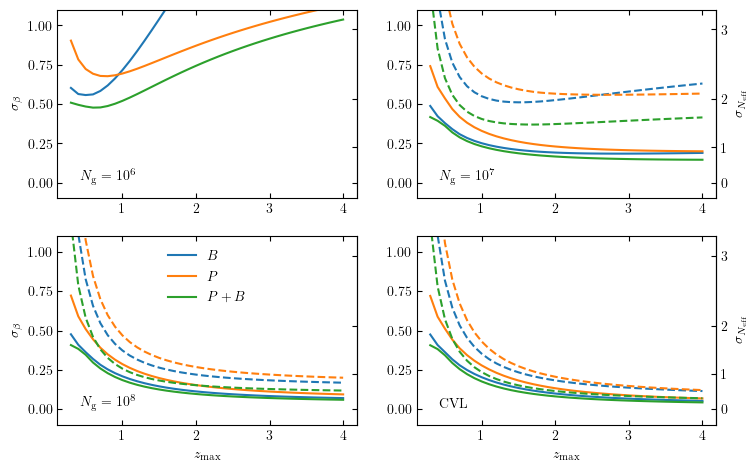

In [96]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5').slice(
    ['ombh2', 'omch2', 'As', 'ns', 'tau', 'thetastar', 'nnu', ])

matplotlib.rcParams['ytick.right'] = False
fig, axs = plt.subplots(2, 2, figsize=(8.5, 5.5))

with h5py.File("idealized_survey_fisher_matrix.hdf5", "r") as f:
    for ng, i in zip([1e6, 1e7, 1e8, 1e100], range(4)):
        sg['N_g'] = ng
        key_svy = 'Ng_%.0e'%ng
        group_svy = f[key_svy]
        zs = np.linspace(0.3, 4, num=38)
        sbs = []
        for z_max in zs:
            sg['z_max'] = z_max
            key_zmax = '%.6f'%z_max
            group_zmax = group_svy[key_zmax]
            svy.update_survey_setups(survey_geometrics=sg, ingredients=ig)
            svy.prepare_alpha_transfer_matrix()
            dadp = svy.alpha_transfer_matrix
            #print(dadp)
            if z_max==0.2:
                continue
            else:
                dadp = np.delete(dadp, 5, 1)
            dadp_pi = np.linalg.pinv(dadp)
            s = dadp_pi.T.dot(cmb_fisher.matrix).dot(dadp_pi)
            cp = fm.fisher(s, svy.alpha_transfer_matrix_entries)
            
            fsp = fm.read_hdf5(group_zmax['P']).slice(['alpha', 'beta'], fuzzy_filter=True)
            fsb = fm.read_hdf5(group_zmax['B']).slice(['alpha', 'beta'], fuzzy_filter=True)
            # print(z_max, cp.keys)
            
            ss = []
            for fs in [fsp.merge(cp), fsb.merge(cp), fsp.merge(fsb).merge(cp), fsp, fsb, fsp.merge(fsb)]:
                sb = fs.constraints()[1]['beta']
                sn = df.sb2sn(sb)
                ss.append(sb)
            sbs.append(ss)
        
        sbs = np.array(sbs)
        ax = axs[i//2, i%2]
        p = ax.plot(zs[:], sbs[:,1], label=r'$B$')
        p = ax.plot(zs[:], sbs[:,4], ls='--', c=p[0].get_color())
        p = ax.plot(zs[:], sbs[:,0], label=r'$P$')
        p = ax.plot(zs[:], sbs[:,3], ls='--', c=p[0].get_color())
        p = ax.plot(zs[:], sbs[:,2], label=r'$P+B$')
        p = ax.plot(zs[:], sbs[:,5], ls='--', c=p[0].get_color())
        
        if i==2:
            ax.legend(loc='upper center', frameon=False)
        if ng<1e100:
            lb = r'$N_{\rm g}=10^{%d}$'%(np.log10(ng))
        else:
            lb = 'CVL'
        ax.annotate(lb, (0.075, 0.075), xycoords='axes fraction', ha='left', va='bottom')
        ax.set_ylim(-0.1, 1.1)
        
        if i%2==0:
            ax.set_ylabel(r'$\sigma_\beta$')
        if i//2==1:
            ax.set_xlabel(r'$z_{\rm max}$')
            
            
        ax_t = ax.secondary_yaxis("right", functions=(df.sb2sn_full, df.sn2sb_full))
        ticks = list(range(13))
        tick_lbs = ['0', '1', '2', '3', '4', '5', '6', '', '', '9', '', '', '12']
        ax_t.set_yticks(ticks)
        if i%2==1:
            ax_t.set_yticklabels(tick_lbs)
            ax_t.set_ylabel(r'$\sigma_{N_{\rm eff}}$')

        if i%2==0:
            ax_t.set_yticklabels([])
            
plt.savefig('plots/constraints_idealized_surveys.pdf', bbox_inches='tight')

In [7]:
matplotlib.rcParams['ytick.right'] = True

## Survey results

In [16]:
from importlib import reload
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interpolate
import scipy.fftpack as fftpack
import copy
import h5py

import galaxy_correlations as gc
reload(gc)

import galaxy_survey as gs
reload(gs)

import fisher_matrix as fm
import defaults as df
reload(df)

<module 'defaults' from 'C:\\Users\\yanlo\\Dropbox\\galaxy_survey\\defaults.py'>

In [17]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams["figure.dpi"] = 100

In [18]:
dfs = df.defaults()

In [19]:
svy = gs.survey()

Text(0, 0.5, '$r(z)$')

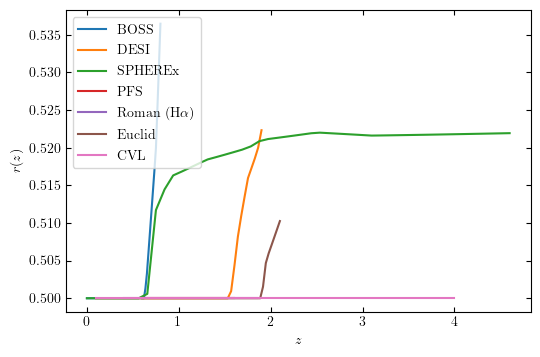

In [26]:
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid, dfs.cvl]
for survey in surveys:
    svy.update_survey_setups(survey_geometrics=survey)
    lbl = survey['name']
    zs = np.linspace(svy.z_min, svy.z_max)
    rs = [svy.reconstruction_rate(z) for z in zs]
    plt.plot(zs, rs, label=lbl)
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$r(z)$')

In [6]:
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid, dfs.cvl]

with h5py.File("survey_fisher_matrix.hdf5", "w") as f:
    for survey in surveys:
        svy.update_survey_setups(survey_geometrics=survey)
        key_svy = survey['short_name']
        print(key_svy, end='\t')
        if key_svy not in list(f.keys()):
            group_svy = f.create_group(key_svy)
            group_svy.attrs['zmax'] = svy.z_max
        else:
            group_svy = f[key_svy]
        for x, l in zip([True, False], ['w', '']):
            if x:
                regions=[{'k_min': 0.01,'k_max': 0.5,'mu_min': -1.0,'mu_max': 1.0}]
            else:
                regions=[{'k_min': 0.01,'k_max': 0.2,'mu_min': -1.0,'mu_max': 1.0}]
            fsp = svy.get_power_spectrum_fisher_matrix(regions=regions, wiggle_only=x, div_mu=50)
            fsb = svy.get_bispectrum_fisher_matrix(wiggle_only=x)
            
            key_fs = 'P'+l
            if key_fs not in list(group_svy.keys()):
                group_fs = group_svy.create_group(key_fs)
            fsp.write_hdf5(group_fs)
            
            key_fs = 'B'+l
            if key_fs not in list(group_svy.keys()):
                group_fs = group_svy.create_group(key_fs)
            fsb.write_hdf5(group_fs)

boss	desi	spherex	pfs	roman	euclid	cvl	

In [7]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')
# CMB+LSS

print('cmb', end='\t')
sb = cmb_fisher.constraints()[1]['nnu']
print('%8.3f (C)'%(sb), end='\n')
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in group_svy.keys():
            fs = fm.read_hdf5(group_svy[fs_key])
            sb = fs.slice(['alpha', 'beta',], exclude=True, fuzzy_filter=True).constraints()[1]['nnu']
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = fs.merge(cmb_fisher).slice(['alpha', 'beta', ], exclude=True).constraints()[1]['nnu']
            print('%.3f (C+%s)'%(sb, fs_key), end=' ')
        print('')

cmb	   0.317 (C)
boss	   6.252 (B) 0.285 (C+B) 2957.120 (Bw) 0.307 (C+Bw)    8.346 (P) 0.296 (C+P)   54.205 (Pw) 0.309 (C+Pw) 
cvl	   0.400 (B) 0.063 (C+B)  220.109 (Bw) 0.242 (C+Bw)    0.819 (P) 0.138 (C+P)    1.366 (Pw) 0.126 (C+Pw) 
desi	   1.495 (B) 0.167 (C+B)  760.228 (Bw) 0.279 (C+Bw)    1.850 (P) 0.187 (C+P)    9.569 (Pw) 0.242 (C+Pw) 
euclid	   1.130 (B) 0.140 (C+B)  589.697 (Bw) 0.274 (C+Bw)    1.445 (P) 0.162 (C+P)    6.508 (Pw) 0.222 (C+Pw) 
pfs	   4.398 (B) 0.274 (C+B) 2276.481 (Bw) 0.301 (C+Bw)    5.734 (P) 0.282 (C+P)   31.880 (Pw) 0.292 (C+Pw) 
roman	   3.196 (B) 0.249 (C+B) 1654.720 (Bw) 0.295 (C+Bw)    4.311 (P) 0.266 (C+P)   18.791 (Pw) 0.281 (C+Pw) 
spherex	   2.582 (B) 0.218 (C+B) 1218.192 (Bw) 0.290 (C+Bw)    2.790 (P) 0.233 (C+P)   13.637 (Pw) 0.277 (C+Pw) 


In [11]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher.hdf5')
# CMB + LSS (phase shift)

print('cmb', end='\t')
sb = df.sb2sn_full(cmb_fisher.constraints()[1]['beta'])
print('%8.3f (C)'%(sb), end='\n')
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in group_svy.keys():
            fs = fm.read_hdf5(group_svy[fs_key]).slice(['nnu', 'thetastar'], exclude=True)
            sb = df.sb2sn_full(fs.constraints()[1]['beta'])
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = df.sb2sn_full(fs.merge(cmb_fisher).constraints()[1]['beta'])
            print('%.3f (C+%s)'%(sb, fs_key), end=' ')
        print('')

cmb	   0.305 (C)
boss	   4.673 (B) 0.112 (C+B)    6.762 (Bw) 0.133 (C+Bw)    5.336 (P) 0.171 (C+P)    5.670 (Pw) 0.155 (C+Pw) 
cvl	   0.756 (B) 0.067 (C+B)    3.121 (Bw) 0.090 (C+Bw)    2.810 (P) 0.115 (C+P)    1.457 (Pw) 0.108 (C+Pw) 
desi	   2.181 (B) 0.082 (C+B)    5.324 (Bw) 0.115 (C+Bw)    3.105 (P) 0.118 (C+P)    3.433 (Pw) 0.119 (C+Pw) 
euclid	   1.789 (B) 0.079 (C+B)    4.915 (Bw) 0.111 (C+Bw)    2.729 (P) 0.113 (C+P)    2.983 (Pw) 0.117 (C+Pw) 
pfs	   4.092 (B) 0.101 (C+B)    6.566 (Bw) 0.128 (C+Bw)    5.061 (P) 0.171 (C+P)    5.366 (Pw) 0.149 (C+Pw) 
roman	   3.515 (B) 0.095 (C+B)    6.296 (Bw) 0.123 (C+Bw)    4.712 (P) 0.151 (C+P)    4.901 (Pw) 0.132 (C+Pw) 
spherex	   3.061 (B) 0.091 (C+B)    5.994 (Bw) 0.119 (C+Bw)    3.779 (P) 0.126 (C+P)    4.023 (Pw) 0.122 (C+Pw) 


In [12]:
ap = dfs.alpha_prior
# alpha prior + LSS
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in group_svy.keys():
            fs = fm.read_hdf5(group_svy[fs_key]).slice(['alpha', 'beta'], exclude=False)
            sb = df.sb2sn_full(fs.constraints()[1]['beta'])
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = df.sb2sn_full(fs.merge(ap).constraints()[1]['beta'])
            print('%.3f (a+%s)'%(sb, fs_key), end=' ')
        print('')

boss	   3.749 (B) 2.170 (a+B)    3.749 (Bw) 2.170 (a+Bw)    4.377 (P) 2.558 (a+P)    4.076 (Pw) 2.554 (a+Pw) 
cvl	   0.542 (B) 0.530 (a+B)    0.542 (Bw) 0.530 (a+Bw)    0.850 (P) 0.818 (a+P)    0.559 (Pw) 0.553 (a+Pw) 
desi	   1.559 (B) 1.303 (a+B)    1.559 (Bw) 1.303 (a+Bw)    2.124 (P) 1.666 (a+P)    1.796 (Pw) 1.544 (a+Pw) 
euclid	   1.275 (B) 1.127 (a+B)    1.275 (Bw) 1.127 (a+Bw)    1.804 (P) 1.508 (a+P)    1.458 (Pw) 1.326 (a+Pw) 
pfs	   3.302 (B) 1.997 (a+B)    3.302 (Bw) 1.997 (a+Bw)    4.042 (P) 2.397 (a+P)    3.636 (Pw) 2.394 (a+Pw) 
roman	   2.732 (B) 1.808 (a+B)    2.732 (Bw) 1.808 (a+Bw)    3.544 (P) 2.212 (a+P)    3.060 (Pw) 2.192 (a+Pw) 
spherex	   2.191 (B) 1.613 (a+B)    2.191 (Bw) 1.613 (a+Bw)    2.699 (P) 1.896 (a+P)    2.332 (Pw) 1.836 (a+Pw) 


In [69]:
# default result
# P, B, P+B, Pw, Bw, Pw+Bw
reload(fm)
reload(df)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')

keys = ['thetastar', 'nnu', 'omch2', 'ombh2', 'As', 'ns', 'tau', 'YHe', ]
sn = cmb_fisher.slice(keys).constraints()[1]['nnu']
print(sn)

polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['b4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]
# polys_ex = ['poly', 'bias']
# polys_ex_w = ['poly', 'bias']

with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman', 'cvl']:
        group_svy = f[svy_key]
        print(getattr(dfs, svy_key)['name'], end=' ')
        fsp = fm.read_hdf5(group_svy['P']).slice(polys_ex, exclude=True, fuzzy_filter=True)
        fsb = fm.read_hdf5(group_svy['B']).slice(polys_ex, exclude=True, fuzzy_filter=True)
        fspw = fm.read_hdf5(group_svy['Pw']).slice(polys_ex_w, exclude=True, fuzzy_filter=True)
        fsbw = fm.read_hdf5(group_svy['Bw']).slice(polys_ex_w, exclude=True, fuzzy_filter=True)
        for fs in [fsp, fsb, fsp.merge(fsb), fspw, fsbw, fspw.merge(fsbw)]:
            fp = fs.merge(cmb_fisher).slice(['alpha', 'beta', ], exclude=True, fuzzy_filter=True)
            sb = fp.constraints()[1]['nnu']
            print('& %.3f'%sb, end=' ')
        print('\\\\')

0.31674263557573606
BOSS & 0.226 & 0.211 & 0.181 & 0.291 & 0.266 & 0.259 \\
DESI & 0.133 & 0.106 & 0.093 & 0.221 & 0.138 & 0.129 \\
Euclid & 0.117 & 0.090 & 0.079 & 0.197 & 0.113 & 0.105 \\
PFS & 0.215 & 0.198 & 0.164 & 0.287 & 0.246 & 0.239 \\
SPHEREx & 0.159 & 0.137 & 0.121 & 0.249 & 0.196 & 0.182 \\
Roman (H$\alpha$) & 0.194 & 0.167 & 0.144 & 0.273 & 0.219 & 0.210 \\
CVL & 0.060 & 0.048 & 0.041 & 0.094 & 0.055 & 0.047 \\


In [65]:
(np.linalg.inv(fp.matrix)@fp.matrix).flatten().min()

-3.3270512586540445e-05

In [68]:
fp.keys

['bs_poly_b3-zmin1.55_zmax1.60',
 'bs_poly_a3-zmin0.75_zmax0.80',
 'ps_poly_a1-zmin0.85_zmax0.90',
 'bs_poly_a3-zmin1.10_zmax1.15',
 'ps_poly_b2-zmin0.70_zmax0.75',
 'bs_poly_a1-zmin1.70_zmax1.75',
 'bs_poly_a0-zmin1.75_zmax1.80',
 'ps_poly_a0-zmin1.50_zmax1.55',
 'bs_poly_b1-zmin1.40_zmax1.45',
 'ps_poly_a3-zmin1.05_zmax1.10',
 'bs_poly_b2-zmin1.60_zmax1.65',
 'bias_bs2-zmin1.65_zmax1.70',
 'ps_poly_a4-zmin1.30_zmax1.35',
 'bias_b1-zmin0.90_zmax0.95',
 'bias_bs2-zmin1.75_zmax1.80',
 'bias_bs2-zmin0.60_zmax0.65',
 'ps_poly_b3-zmin1.55_zmax1.60',
 'bs_poly_b3-zmin0.70_zmax0.75',
 'bias_b2-zmin0.40_zmax0.45',
 'bias_bs2-zmin1.00_zmax1.05',
 'ps_poly_a2-zmin1.20_zmax1.25',
 'bs_poly_b2-zmin0.95_zmax1.00',
 'bias_bs2-zmin0.90_zmax0.95',
 'ps_poly_a3-zmin1.40_zmax1.45',
 'bs_poly_a1-zmin1.05_zmax1.10',
 'bs_poly_a2-zmin0.50_zmax0.55',
 'ns',
 'bs_poly_a3-zmin0.95_zmax1.00',
 'bs_poly_a1-zmin1.30_zmax1.35',
 'bs_poly_a0-zmin0.40_zmax0.45',
 'bias_b2-zmin1.40_zmax1.45',
 'bs_poly_b2-zmin1.35_

In [27]:
x = 0.0001
dbdn = (df.n2b(3.046+x)-df.n2b(3.046))/x
dbdn

0.1940542848166693

boss	   3.749 (Bw) 2.170 (a+Bw)    4.076 (Pw) 2.554 (a+Pw) 
cvl	   0.542 (Bw) 0.530 (a+Bw)    0.559 (Pw) 0.553 (a+Pw) 
desi	   1.559 (Bw) 1.303 (a+Bw)    1.796 (Pw) 1.544 (a+Pw) 
euclid	   1.275 (Bw) 1.127 (a+Bw)    1.458 (Pw) 1.326 (a+Pw) 
pfs	   3.302 (Bw) 1.997 (a+Bw)    3.636 (Pw) 2.394 (a+Pw) 
roman	   2.732 (Bw) 1.808 (a+Bw)    3.060 (Pw) 2.192 (a+Pw) 
spherex	   2.191 (Bw) 1.613 (a+Bw)    2.332 (Pw) 1.836 (a+Pw) 


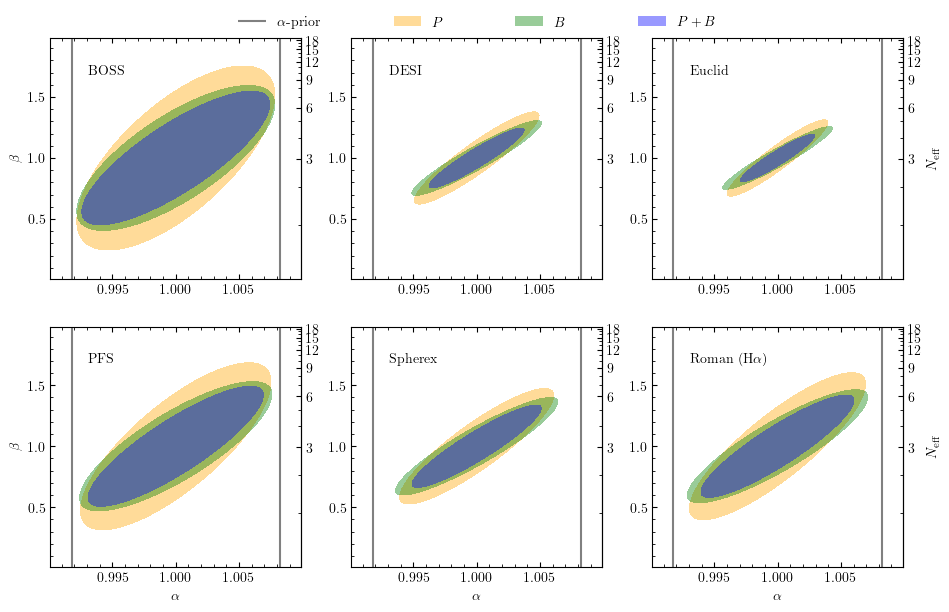

In [9]:
ap = dfs.alpha_prior
# alpha prior + LSS (alpha, beta only)
with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in f.keys():
        group_svy = f[svy_key]
        print(svy_key, end='\t')
        for fs_key in ['Bw', 'Pw']:
            #fs = fm.read_hdf5(group_svy[fs_key]).slice(['nnu', 'thetastar'], exclude=True)
            fs = fm.read_hdf5(group_svy[fs_key]).slice(['alpha', 'beta'])
            sb = df.sb2sn_full(fs.constraints()[1]['beta'])
            print('%8.3f (%s)'%(sb, fs_key), end=' ')
            sb = df.sb2sn_full(fs.merge(ap).constraints()[1]['beta'])
            print('%.3f (a+%s)'%(sb, fs_key), end=' ')
        print('')
        
        
        
from scipy import stats        
svys_label = ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman']
svys_title = [r'BOSS', r'DESI', r'Euclid', r'PFS', r'Spherex', r'Roman (H$\alpha$)']
stretch_factor = 1.

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

matplotlib.rcParams['ytick.right'] = False


fig, axs = plt.subplots(2, 3, figsize=(11, 7))
xrange, yrange = 9.9e-3, 0.99
xymean = [1, 1]
x, y = np.mgrid[xymean[0]-xrange:xymean[0]+xrange:.0001, xymean[1]-yrange:xymean[1]+yrange:.01]
pos = np.dstack((x, y))
colors = ['grey', 'orange', 'green', 'blue',]
legends = [r'$\alpha$-prior', r'$P$', r'$B$', r'$P+B$']


with h5py.File('survey_fisher_matrix.hdf5', 'r') as f:
    for r in range(2):
        for i in range(3):
            ax = axs[r, i]
            svy_key = svys_label[r*3+i]
            group_svy = f[svy_key]
            title = svys_title[r*3+i]
            ax.annotate(title, (0.15, 0.85), xycoords='axes fraction')
            #ax.set_title(title)

            fishers = []
            prior = ap
            fishers.append(prior)
            
            fsp = fm.read_hdf5(group_svy['Pw']).slice(['poly', ], fuzzy_filter=True, exclude=True)
            fsb = fm.read_hdf5(group_svy['Bw']).slice(['poly', ], fuzzy_filter=True, exclude=True)
            fspb = fsp.merge(fsb)
            
            fsp = fsp.merge(prior).slice(['nnu', 'YHe'], exclude=True)
            fsb = fsb.merge(prior).slice(['nnu', 'YHe'], exclude=True)
            fspb = fspb.merge(prior).slice(['nnu', 'YHe'], exclude=True)
            #print(fsp.keys)
            fishers.append(fsp)
            fishers.append(fsb)
            fishers.append(fspb)

            j = 0
            nms = []
            lgs = []
            for fisher in fishers:
                #cov = np.linalg.inv(fisher)[:2, :2]
                cov = fisher.slice(['alpha', 'beta']).inverse().slice(['alpha', 'beta']).matrix
                if cov[1, 1] > 1e5:
                    cov[1, 1] = 1e5
                # print(cov)
                rv = stats.multivariate_normal(xymean, cov, allow_singular=True)
                if j == 0:
                    cf = ax.contour(x, y, rv.pdf(pos), levels=[rv.pdf(xymean)*np.e**(-0.5*stretch_factor**2)], colors=[colors[j]])
                    nm, lbl = cf.legend_elements()
                    if r*3+i == 1:
                        nms += nm
                        lgs += [legends[j]]
                else:
                    cf = ax.contourf(x, y, rv.pdf(pos), levels=[rv.pdf(xymean)*np.e**(-0.5*stretch_factor**2), 10086], colors=[colors[j]], alpha=0.4)
                    nm, lbl = cf.legend_elements()
                    if r*3+i == 1:
                        nms += nm
                        lgs += [legends[j]]
#                     if r*3+i == 2 and (j == 2 or j == 3):
#                         nms += nm
#                         lgs += [legends[j]]

                if nms != []:
                    #ax.legend(nms, lgs, ncol=2)  
                    ax.legend(nms, lgs, bbox_to_anchor=(-0.5, 1.05, 2, .1), loc='upper right', mode='expand', ncol=7, frameon=False)

                if j == 0:
                    ax_r = ax.secondary_yaxis("right", functions=(df.b2n, df.n2b))
                    ax_r.yaxis.set_major_locator(MultipleLocator(3))
                    ax_r.yaxis.set_minor_locator(MultipleLocator(1))
                    if i == 2:
                        ax_r.set_ylabel(r'$N_{\rm eff}$')
#                     else:
#                         ax_r.set_yticks([])

                j += 1
            
                ax.xaxis.set_major_locator(MultipleLocator(0.005))
                ax.xaxis.set_minor_locator(MultipleLocator(0.001))
                ax.yaxis.set_major_locator(MultipleLocator(0.5))
                ax.yaxis.set_minor_locator(MultipleLocator(0.1))
                
            if i == 0:
                ax.set_ylabel(r'$\beta$')
            if r == 1:
                ax.set_xlabel(r'$\alpha$')
            
plt.savefig('plots/contours-alpha-beta.pdf', bbox_inches='tight')
matplotlib.rcParams['ytick.right'] = True
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


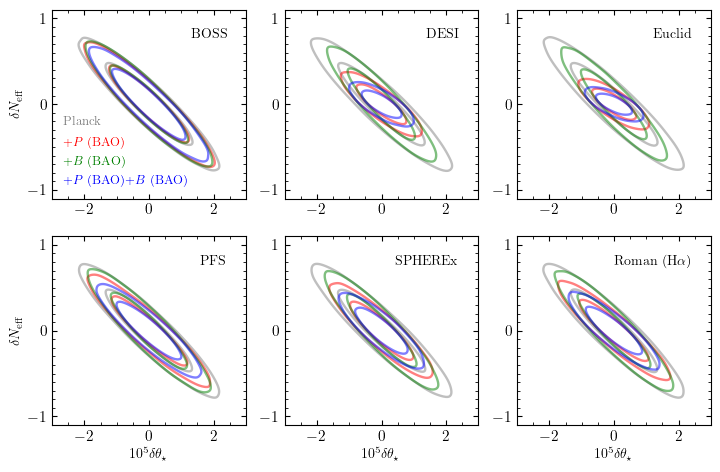

<Figure size 600x450 with 0 Axes>

In [98]:
from getdist import plots, MCSamples
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

show_wiggles_only = True


fig, axs = plt.subplots(2, 3, figsize=(8.5, 5.5))

colors = ['grey', 'red', 'green', 'blue',]
alphas = [0.5]*4

legends = [r'Planck', r'+$P$', r'+$B$', r'+$P$+$B$']
if show_wiggles_only:
    legends = [r'Planck', r'+$P$ (BAO)', r'+$B$ (BAO)', r'+$P$ (BAO)+$B$ (BAO)']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')
norms = {'thetastar': 1e5,'ombh2': 1e4,'As': 1e10,}
svys_label = ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman']
svys_title = [r'BOSS', r'DESI', r'Euclid', r'PFS', r'SPHEREx', r'Roman (H$\alpha$)']
random_state = np.random.default_rng(10)
g = plots.get_single_plotter()

with h5py.File('survey_fisher_matrix.hdf5', 'r') as f:
    for r in range(2):
        for i in range(3):
            ax = axs[r, i]
            svy_key = svys_label[r*3+i]
            group_svy = f[svy_key]
            title = svys_title[r*3+i]
            ax.annotate(title, (0.9, 0.9), xycoords='axes fraction', ha='right', va='top')
            #ax.set_title(title)

            fishers = []
            prior = cmb_fisher
            fishers.append(prior)
            if show_wiggles_only:
                fsp = fm.read_hdf5(group_svy['Pw']).slice(['poly', ], fuzzy_filter=True, exclude=True)
                fsb = fm.read_hdf5(group_svy['Bw']).slice(['poly', ], fuzzy_filter=True, exclude=True)
            else:
                fsp = fm.read_hdf5(group_svy['P']).slice(['poly', ], fuzzy_filter=True, exclude=True)
                fsb = fm.read_hdf5(group_svy['B']).slice(['poly', ], fuzzy_filter=True, exclude=True)
            
            fspb = fsp.merge(fsb)
            
            fsp = fsp.merge(prior).slice(['alpha', 'beta'], exclude=True)
            fsb = fsb.merge(prior).slice(['alpha', 'beta'], exclude=True)
            fspb = fspb.merge(prior).slice(['alpha', 'beta'], exclude=True)

            fishers.append(fsp)
            fishers.append(fsb)
            fishers.append(fspb)

            samples = []
            for fisher, legend in zip(fishers, legends):
                cov = fisher.normalize(norms).matrix
                cc = np.linalg.inv(cov)
                samps = random_state.multivariate_normal([0]*fisher.ndim, cc, size=100000)
                samples.append(MCSamples(samples=samps,names=fisher.keys, labels=fisher.keys, label=legend))
#             g.plot_1d(samples, 'thetastar', filled=False, ax=ax, lims=[-3, 3,],
#                      do_xlabel=False, do_ylabel=False, colors=colors, alphas=alphas)
            g.plot_2d(samples, ['thetastar', 'nnu'], filled=False, ax=ax, lims=[-3, 3, -1.1, 1.1],
                     do_xlabel=False, do_ylabel=False, colors=colors, alphas=alphas)
            if i==0 and r==0:
                g.settings.figure_legend_frame = False
#                 g.add_legend(legends, legend_loc='upper right', ax=ax, legend_ncol=7, figure_legend_outside=True,
#                             bbox_to_anchor=(0.7, 1.1, 2, .1), mode='expand', colored_text=True)
                g.add_legend(legends, legend_loc='lower left', ax=ax, colored_text=True, fontsize=9)
            
            if i == 0:
                ax.set_ylabel(r'$\delta N_{\rm eff}$')
            if r == 1:
                ax.set_xlabel(r'$10^5 \delta \theta_\star$')
            ax.xaxis.set_minor_locator(MultipleLocator(0.5))
            ax.yaxis.set_minor_locator(MultipleLocator(0.1))

if show_wiggles_only:
    suf = '-bao'
else:
    suf = ''
fig.savefig('plots/contours-thetastar-nnu%s.pdf'%suf, bbox_inches='tight')
plt.show()

In [100]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5').slice(
    ['ombh2', 'omch2', 'As', 'ns', 'tau', 'thetastar', 'nnu'])

0.6569208033291996 Removed no burn in
0.4945369195089593 Removed no burn in
0.4374556800760126 Removed no burn in
2.0671670510629614 Removed no burn in
1.4652352276807774 Removed no burn in
1.1726436080610525 Removed no burn in
0.24357770939144407 Removed no burn in
0.18588201243950747 Removed no burn in
0.16827970863538763 Removed no burn in
0.5798153770123499 Removed no burn in
0.3828921005774358 Removed no burn in
0.3095988916191012 Removed no burn in


<ipython-input-185-e3b2a565e8c1>:40: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)
<ipython-input-185-e3b2a565e8c1>:40: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


0.1958457880363222 Removed no burn in
0.14787932859000885 Removed no burn in
0.13490247250805681 Removed no burn in
0.4647026935683183 Removed no burn in
0.2988048535390918 Removed no burn in
0.24199533073054286 Removed no burn in
0.5133248698121402 Removed no burn in
0.36730044938030154 Removed no burn in
0.32783458647746605 Removed no burn in
1.7157583611991487 Removed no burn in
1.1508967258570766 Removed no burn in
0.9266368226128736 Removed no burn in


<ipython-input-185-e3b2a565e8c1>:40: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)
<ipython-input-185-e3b2a565e8c1>:40: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


0.40362258522971184 Removed no burn in
0.3310557234201234 Removed no burn in
0.2944333181726199 Removed no burn in
0.854581614730568 Removed no burn in
0.6046557842430647 Removed no burn in
0.4812099849026365 Removed no burn in


<ipython-input-185-e3b2a565e8c1>:40: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


0.39076525961879355 Removed no burn in
0.278751800585324 Removed no burn in
0.25002950386898143 Removed no burn in
1.3144050318198066 Removed no burn in
0.8376000282497149 Removed no burn in
0.6807039365687017 Removed no burn in


<ipython-input-185-e3b2a565e8c1>:40: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)


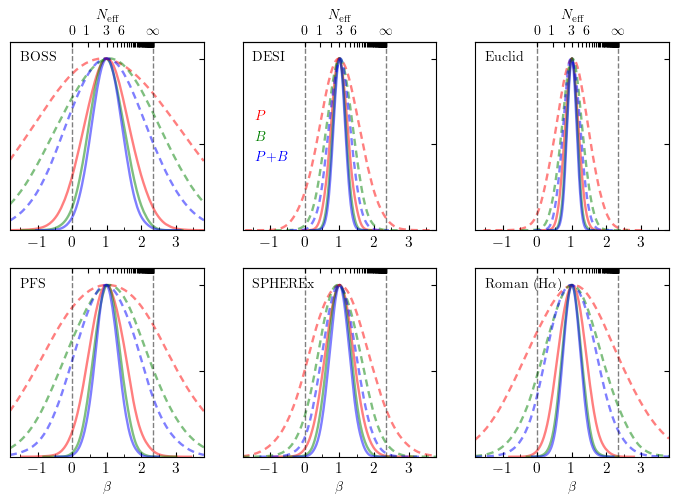

<Figure size 600x450 with 0 Axes>

In [185]:
from getdist import plots, MCSamples
reload(df)

nsamp = 10000
random_state = np.random.default_rng(10) # seed random generator
colors = ['red', 'green', 'blue',]
legends = [r'$P$', r'$B$', r'$P$+$B$',]
alphas = [0.5]*6
svys_keys = ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman']
svys_title = [r'BOSS', r'DESI', r'Euclid', r'PFS', r'SPHEREx', r'Roman (H$\alpha$)']

fig, axs = plt.subplots(2, 3, figsize=(8.5, 5.5))
g = plots.get_single_plotter()
matplotlib.rcParams['xtick.top'] = False

with h5py.File("survey_fisher_matrix.hdf5", 'r') as f:
    for i in range(2):
        for j in range(3):
            ax = axs[i, j]
            svy_key = svys_keys[i*3+j]
            title = svys_title[i*3+j]
            ax.annotate(title, (0.05, 0.95), xycoords='axes fraction', ha='left', va='top')
            
            svy.update_survey_setups(survey_geometrics=getattr(dfs, svy_key))
            svy.prepare_alpha_transfer_matrix()
            dadp = svy.alpha_transfer_matrix
            dadp = np.delete(dadp, 5, 1)
            dadp_pi = np.linalg.pinv(dadp)
            s = dadp_pi.T.dot(cmb_fisher.matrix).dot(dadp_pi)
            cp = fm.fisher(s, svy.alpha_transfer_matrix_entries)

            fsp = fm.read_hdf5(f[svy_key]['P']).slice(['alpha', 'beta'], fuzzy_filter=True)
            fsb = fm.read_hdf5(f[svy_key]['B']).slice(['alpha', 'beta'], fuzzy_filter=True)
            samples = []
            fishers = [cp.merge(fsp), cp.merge(fsb), cp.merge(fsp).merge(fsb), fsp, fsb, fsp.merge(fsb)]
            for ma, k in zip(fishers, range(6)):
                print(ma.constraints()[1]['beta'], end=' ')
                cov = np.linalg.inv(ma.matrix)
                ndim = len(cov)
                samps = random_state.multivariate_normal([1]*ndim, cov, size=nsamp)
                names = ma.keys
                labels =  ma.keys
                samples.append(MCSamples(samples=samps,names = names, labels = labels))

            g.plot_1d(samples, 'beta', ax=ax, colors=colors+colors, ls=['-']*3+['--']*3, lims=[-1.8, 3.8],
                      do_xlabel=False, do_ylabel=False,alphas=alphas)
            
            if i==0 and j==1:
                g.settings.figure_legend_frame = False
                g.add_legend(legends, legend_loc='center left', ax=ax, colored_text=True, fontsize=10)

            if i == 1:
                ax.set_xlabel(r'$\beta$')
            ax.xaxis.set_minor_locator(MultipleLocator(0.5))
            

            ax_t = ax.secondary_xaxis("top", functions=(df.b2n, df.n2b))
            ticks = list(range(100))
            tick_lbs = ['0', '1', '', '3', '', '', '6']+['']*92+[r'$\infty$']
            ax_t.set_xticks(ticks)
            if i==0:
                ax_t.set_xticklabels(tick_lbs)
                ax_t.set_xlabel(r'$N_{\rm eff}$')
            if i==1:
                ax_t.set_xticklabels([])
                
            ax.plot([0,0], [0, 1.5], 'k--', lw=1, alpha=.5)
            ax.plot([df.n2b(100),df.n2b(100)], [0, 1.5], 'k--', lw=1, alpha=.5)
            #ax.set_ylim(0, 1)

fig.savefig('plots/dist-beta.pdf', bbox_inches='tight')
plt.show()

#matplotlib.rcParams['xtick.top'] = True

In [188]:
# default result
# Pw, Bw, Pw+Bw (phase shift only)
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5').slice(
    ['ombh2', 'omch2', 'As', 'ns', 'tau', 'thetastar', 'nnu'])

polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['a4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]

polys_ex_w = ['poly', 'bias']

with h5py.File("survey_fisher_matrix.hdf5", "r") as f:
    for svy_key in ['boss', 'desi', 'euclid', 'pfs', 'spherex', 'roman', 'cvl']:
        svy.update_survey_setups(survey_geometrics=getattr(dfs, svy_key))
        svy.prepare_alpha_transfer_matrix()
        dadp = svy.alpha_transfer_matrix
        dadp = np.delete(dadp, 5, 1)
        dadp_pi = np.linalg.pinv(dadp)
        s = dadp_pi.T.dot(cmb_fisher.matrix).dot(dadp_pi)
        cp = fm.fisher(s, svy.alpha_transfer_matrix_entries)
            
            
        group_svy = f[svy_key]
        print(getattr(dfs, svy_key)['name'], end=' ')
        fsp = fm.read_hdf5(f[svy_key]['P']).slice(['alpha', 'beta'], fuzzy_filter=True)
        fsb = fm.read_hdf5(f[svy_key]['B']).slice(['alpha', 'beta'], fuzzy_filter=True)

        for fs in [fsp, fsb, fsp.merge(fsb), fsp.merge(cp), fsb.merge(cp), fsp.merge(fsb).merge(cp)]:
            sb = fs.constraints()[1]['beta']
            sn = df.sb2sn(sb)
            print('& %.3f'%sn, end=' ')
        print('\\\\')

BOSS & 10.652 & 7.551 & 6.043 & 3.385 & 2.548 & 2.254 \\
DESI & 2.988 & 1.973 & 1.595 & 1.255 & 0.958 & 0.867 \\
Euclid & 2.395 & 1.540 & 1.247 & 1.009 & 0.762 & 0.695 \\
PFS & 8.842 & 5.931 & 4.775 & 2.645 & 1.893 & 1.554 \\
SPHEREx & 4.404 & 3.116 & 2.480 & 2.080 & 1.706 & 1.517 \\
Roman (H$\alpha$) & 6.773 & 4.316 & 3.508 & 2.014 & 1.436 & 1.288 \\
CVL & 0.959 & 0.585 & 0.472 & 0.387 & 0.270 & 0.233 \\


Removed no burn in
Removed no burn in
Removed no burn in


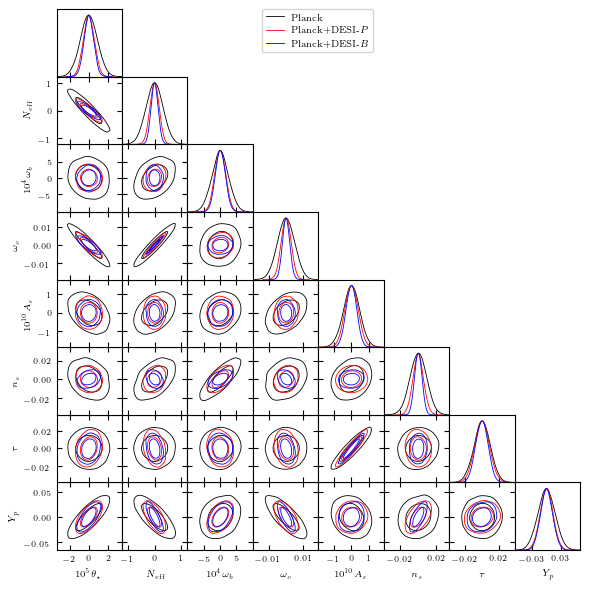

Removed no burn in
Removed no burn in
Removed no burn in


C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:139: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([0]*ndim, cc, size=nsamp)


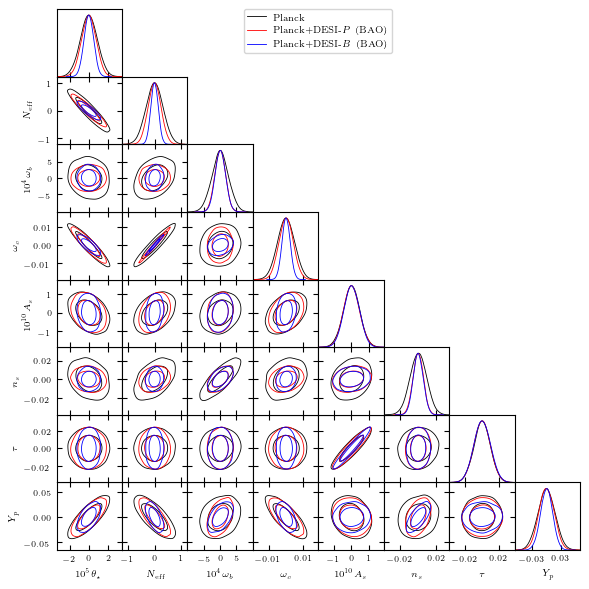

Removed no burn in
Removed no burn in
Removed no burn in


C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:139: RuntimeWarning: covariance is not positive-semidefinite.
  samps = random_state.multivariate_normal([0]*ndim, cc, size=nsamp)


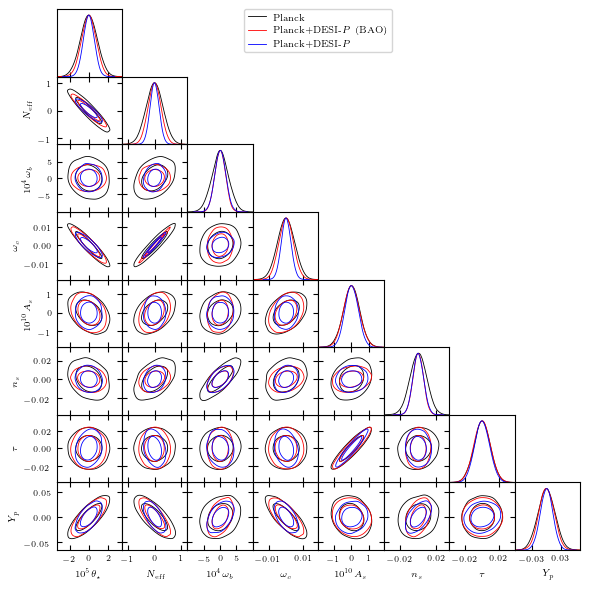

In [68]:
reload(fm)
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')

with h5py.File("survey_fisher_matrix.hdf5", 'r') as f:
    fsb = fm.read_hdf5(f['desi']['B']).slice(['alpha', 'beta'], exclude=True)
    fsbw = fm.read_hdf5(f['desi']['Bw']).slice(['alpha', 'beta'], exclude=True)
    fsp = fm.read_hdf5(f['desi']['P']).slice(['alpha', 'beta'], exclude=True)
    fspw = fm.read_hdf5(f['desi']['Pw']).slice(['alpha', 'beta'], exclude=True)
    
    keys = ['thetastar', 'nnu', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe']
    labels =  [r'$10^5\theta_\star$', r'$ N_{\rm eff}$', r'$10^4\omega_b$', r'$\omega_c$', 
           r'$ 10^{10}A_s$', r'$ n_s$', r'$\tau$', r'$ Y_p$']
    norms = {'thetastar': 1e5,'ombh2': 1e4,'As': 1e10,}
    
    #
    fm.triangle_plot([cmb_fisher, fsp.merge(cmb_fisher), fsb.merge(cmb_fisher), ], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$', 'Planck+DESI-$B$', ], 
                 parameter_labels=labels, norms=norms, marginalize=True)
    plt.savefig('fisher-matrix-broadband-corner.pdf', bbox_inches='tight')
    plt.show()
    
    #
    fm.triangle_plot([cmb_fisher, cmb_fisher.merge(fspw), cmb_fisher.merge(fsbw)], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$ (BAO)', 'Planck+DESI-$B$ (BAO)', ], 
                 parameter_labels=labels, norms=norms, marginalize=True)
    plt.savefig('fisher-matrix-wiggle-corner.pdf', bbox_inches='tight')
    plt.show()
    
    #
    fm.triangle_plot([cmb_fisher, cmb_fisher.merge(fspw), cmb_fisher.merge(fsp)], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$ (BAO)', 'Planck+DESI-$P$', ], 
                 parameter_labels=labels, norms=norms, marginalize=True)
#     plt.savefig('fisher-matrix-wiggle-corner.pdf', bbox_inches='tight')
    plt.show()

Removed no burn in
Removed no burn in
Removed no burn in


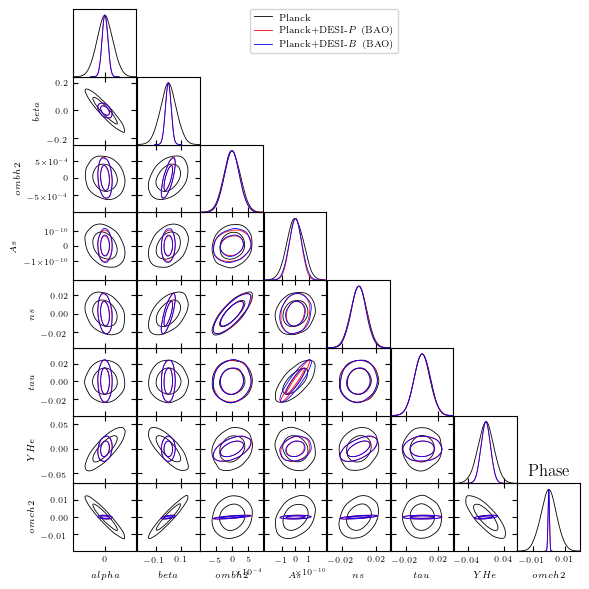

Removed no burn in
Removed no burn in
Removed no burn in


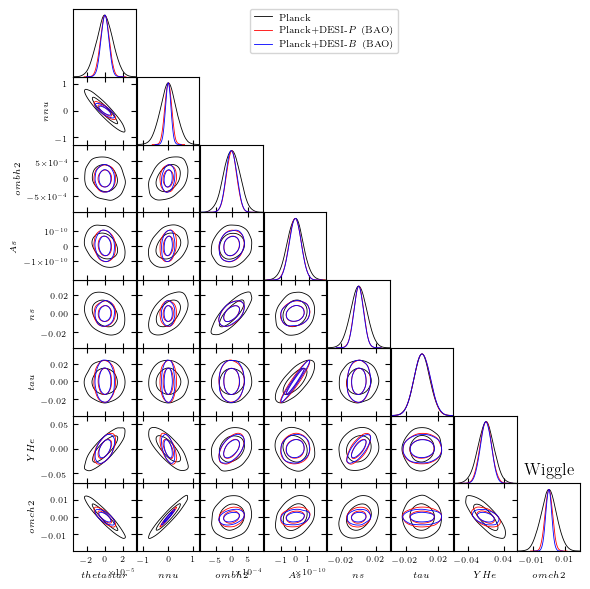

In [92]:
reload(fm)
keys = ['alpha', 'beta', 'ombh2', 'As', 'ns', 'tau', 'YHe', 'omch2']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher.hdf5').slice(keys)

with h5py.File("survey_fisher_matrix.hdf5", 'r') as f:    
    fsbw = fm.read_hdf5(f['desi']['Bw']).slice(keys)
    fspw = fm.read_hdf5(f['desi']['Pw']).slice(keys)
    labels =  keys
    norms = {}
    
    #
    fm.triangle_plot([cmb_fisher, cmb_fisher.merge(fspw), cmb_fisher.merge(fsbw)], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$ (BAO)', 'Planck+DESI-$B$ (BAO)', ], 
                 parameter_labels=labels, norms=norms)
    plt.title('Phase')
    plt.show()
    
    
reload(fm)
keys = ['thetastar', 'nnu', 'ombh2', 'As', 'ns', 'tau', 'YHe', 'omch2']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5').slice(keys)

with h5py.File("survey_fisher_matrix.hdf5", 'r') as f:
    fsbw = fm.read_hdf5(f['desi']['Bw']).slice(keys)
    fspw = fm.read_hdf5(f['desi']['Pw']).slice(keys)
    labels =  keys
    norms = {}
    
    #
    fm.triangle_plot([cmb_fisher, cmb_fisher.merge(fspw), cmb_fisher.merge(fsbw)], keys=keys, 
                 fisher_labels=['Planck', 'Planck+DESI-$P$ (BAO)', 'Planck+DESI-$B$ (BAO)', ], 
                 parameter_labels=labels, norms=norms)
    plt.title('Wiggle')
    plt.show()

['thetastar', 'nnu', 'ombh2', 'omch2', 'As', 'ns', 'tau', 'YHe']


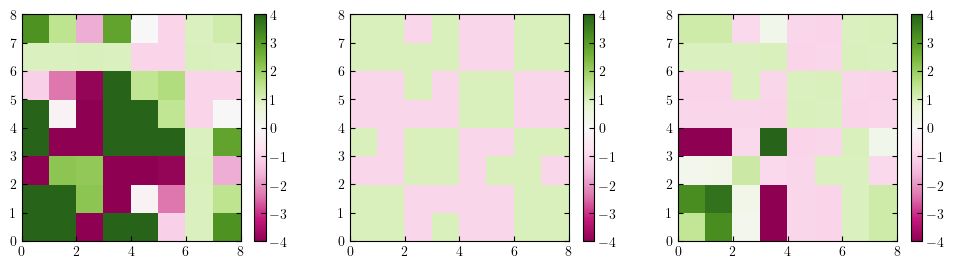

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
i = 0
print(keys)
for fs in [cmb_fisher.merge(fsb), cmb_fisher, cmb_fisher.merge(fsbw)]:
    matrix0 = cmb_fisher.slice(keys).matrix
    z = fs.slice(keys).matrix/np.abs(matrix0)
    ax = axs[i]
    c = ax.pcolormesh(z, vmax=4, vmin=-4, cmap='PiYG')
    fig.colorbar(c, ax=ax)
    i += 1

### Kmax dependence

In [71]:
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid,]
ks = np.linspace(0.02, 0.3, num=29)

In [11]:
with h5py.File("survey_fisher_matrix_kmax.hdf5", "w") as f:
    for survey in surveys:
        svy.update_survey_setups(survey_geometrics=survey)
        key_svy = survey['short_name']
        print(key_svy, end='\t')
        if key_svy not in list(f.keys()):
            group_svy = f.create_group(key_svy)
            group_svy.attrs['zmax'] = svy.z_max
        else:
            group_svy = f[key_svy]
        for i in tqdm(range(len(ks))):
            kmax = ks[i]
            key_k = '%d'%i
            if key_k not in list(group_svy.keys()):
                group_k = group_svy.create_group(key_k)
                group_k.attrs['kmax'] = kmax
            else:
                group_k = group_svy[key_k]
            
            for x, l in zip([True, False], ['w', '']):
                fsp = svy.get_power_spectrum_fisher_matrix(wiggle_only=x, div_k = int((kmax-0.01)/0.0025),
                            regions=[{'k_min': 0.01,'k_max': kmax,'mu_min': -1.0,'mu_max': 1.0}])
                div = int(max(6, (kmax)/0.045))
                print(div, end='')
                fsb = svy.get_bispectrum_fisher_matrix(wiggle_only=x,
                            regions = [{'coordinate': 'cartesian',\
                                            'mu_opt': True,\
                                            'bounds': ((0.01, kmax),(0.01, kmax),(0.01, kmax),(0, 1),(0, 6.283185307179586)),\
                                            'divideby': 'num',\
                                            'divs': (div, div, div, div, div)}], verbose=True)

                key_fs = 'P'+l
                if key_fs not in list(group_k.keys()):
                    group_fs = group_k.create_group(key_fs)
                fsp.write_hdf5(group_fs)

                key_fs = 'B'+l
                if key_fs not in list(group_k.keys()):
                    group_fs = group_k.create_group(key_fs)
                fsb.write_hdf5(group_fs)
                print('+'+l, end='')

boss	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+6>>>>>>>>+w6>>>>>>>>+desi	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+6>>>>>>>>>>>+w6>>>>>>>>>>>+pfs	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+6>>>>>+w6>>>>>+roman	

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>>>>>>>>

  0%|          | 0/29 [00:00<?, ?it/s]

6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>>>>>>>>>>>>>>>+6>>>>>>>>>>>>>>>+w6>

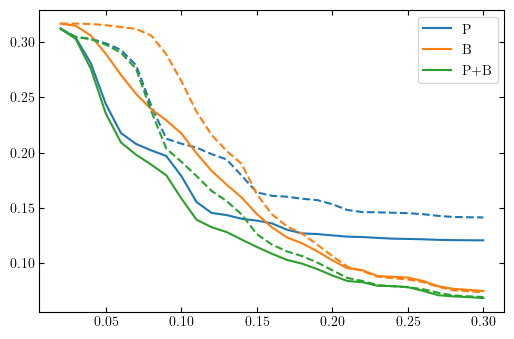

In [72]:
import h5py
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')
reload(fm)
ks = np.linspace(0.02, 0.3, num=29)

polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['a5', 'b4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]

polys_ex = ['poly_', 'bias']
polys_ex_w = ['poly_', 'bias']

sns = []
with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    for i in range(len(ks)):
        temp = []
        kmax = ks[i]
        key_k = str(i)
        fv = f['desi']
        fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        for fs in [fsp, fspw, fsb, fsbw, fsp.merge(fsb), fspw.merge(fsbw)]:
            fmt = fs.merge(cmb_fisher).slice(['alpha', 'beta',], exclude=True)
            sn = fmt.constraints()[1]['nnu']
            #print(fmt.keys)
            temp.append(sn)
        sns.append(temp)
        
sns = np.array(sns)

for j, l in zip(range(3), ['P', 'B', 'P+B']):
    k = 0+j*2
    pl = plt.plot(ks, sns[:,k], label=l)
    k = 1+j*2
    pl = plt.plot(ks, sns[:,k], ls='--', c=pl[0].get_color())
    
plt.legend()
plt.show()

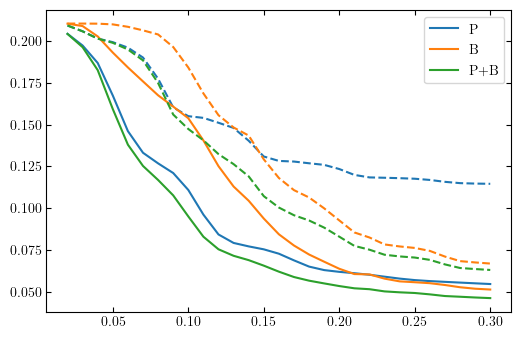

In [73]:
sns = []
with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    for i in range(len(ks)):
        temp = []
        kmax = ks[i]
        key_k = str(i)
        fv = f['desi']
        fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
        fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
        for fs in [fsp, fspw, fsb, fsbw, fsp.merge(fsb), fspw.merge(fsbw)]:
            sn = fs.merge(cmb_fisher).slice(['alpha', 'beta', 'YHe'], exclude=True).constraints()[1]['nnu']
            temp.append(sn)
        sns.append(temp)
        
sns = np.array(sns)

for j, l in zip(range(3), ['P', 'B', 'P+B']):
    k = 0+j*2
    pl = plt.plot(ks, sns[:,k], label=l)
    k = 1+j*2
    pl = plt.plot(ks, sns[:,k], ls='--', c=pl[0].get_color())
    
plt.legend()
plt.show()

In [74]:
def reshape_lines(s):
    for i in range(len(s)-1):
        k = len(s)-i-1
        if s[k-1]<s[k]:
            s[k-1] = s[k]
        if s[k-1]>cmb_fisher.constraints()[1]['nnu']:
            s[k-1] = cmb_fisher.constraints()[1]['nnu']
    return s

boss boss 

C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs roman 

C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs

C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss boss desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex spherex pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs pfs roman 

C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman roman euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid euclid 

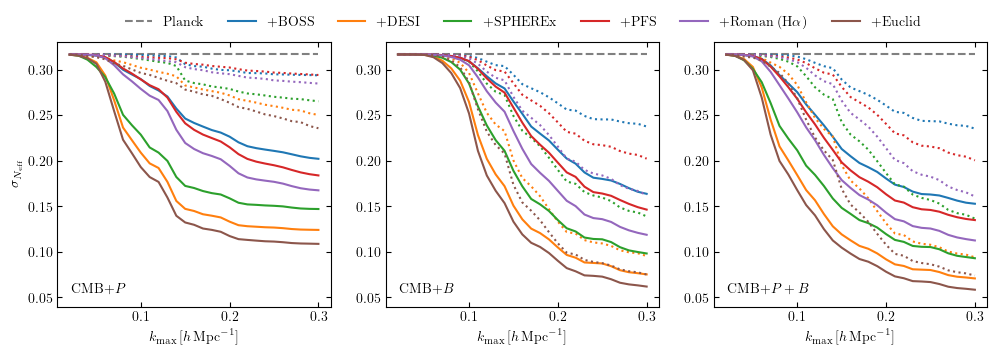

In [76]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), sharex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.07)
surveys = [dfs.boss, dfs.desi, dfs.spherex, dfs.pfs, dfs.roman, dfs.euclid,]
# surveys = [dfs.boss, dfs.desi]
#surveys = [dfs.euclid]
cmb_survey = 'planck'
#cmb_survey = 'cmb_s3'
#cmb_survey = 'cmb_s4'
cmb_fisher = fm.read_hdf5('%s_cmb_fisher_original.hdf5'%cmb_survey)

cps_ex = ['alpha', 'beta',]



polys_ex = ['a0', 'a1', 'a2', 'a3', 'a4', 'b2', 'b3', 'b4', 'b5']
polys_ex_w = ['a4', 'b5']

polys_ex = ['poly_'+x for x in polys_ex]
polys_ex_w = ['poly_'+x for x in polys_ex_w]

# polys_ex = ['poly', 'bias']
# polys_ex_w = ['poly', 'bias']

if cmb_survey == 'planck':
    cmb_label = 'Planck'
    ymin, ymax = 0.04, 0.33
if cmb_survey == 'cmb_s3':
    cmb_label = 'CMB-S3'
    ymin, ymax = 0.03, 0.125
    
if cmb_survey == 'cmb_s4':
    cmb_label = 'CMB-S4'
    ymin, ymax = 0.025, 0.087

ax = axs[0]
ax.plot(ks, np.repeat(cmb_fisher.slice(cps_ex, exclude=True).constraints()[1]['nnu'], len(ks)), ls='--', label=cmb_label, c='grey')

with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    for survey in surveys:
        sns = []
        key_svy = survey['short_name']
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            for fs in [fsp, fspw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        if key_svy in ['boss', 'desi']:
            label = '+'+survey['name']
        else:
            label = None
            label = '+'+survey['name']
        pl = ax.plot(ks, reshape_lines(sns[:,0]), label=label)
        ax.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
ax.legend(bbox_to_anchor=(0.2, 1.05, 3, .1), loc='upper right', mode='expand', ncol=7, prop={'size': 10}, frameon=False)
ax.annotate(r'CMB+$P$', (0.05, 0.05), xycoords='axes fraction')
ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
ax.set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')
ax.set_ylim(ymin, ymax)

ax = axs[1]
ax.plot(ks, np.repeat(cmb_fisher.slice(cps_ex, exclude=True).constraints()[1]['nnu'], len(ks)), ls='--', c='grey')

with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    for survey in surveys:
        sns = []
        key_svy = survey['short_name']
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            for fs in [fsb, fsbw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        if key_svy in ['euclid', 'pfs']:
            label = '+'+survey['name']
        else:
            label = None
        pl = ax.plot(ks, reshape_lines(sns[:,0]), label=label)
        ax.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
#ax.legend()
ax.annotate(r'CMB+$B$', (0.05, 0.05), xycoords='axes fraction')
#ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
ax.set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')
ax.set_ylim(ymin, ymax)

ax = axs[2]
ax.plot(ks, np.repeat(cmb_fisher.slice(cps_ex, exclude=True).constraints()[1]['nnu'], len(ks)), ls='--', c='grey')

with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    for survey in surveys:
        sns = []
        key_svy = survey['short_name']
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsb = fm.read_hdf5(fv[key_k]['B']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fsbw = fm.read_hdf5(fv[key_k]['Bw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(polys_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(polys_ex_w, fuzzy_filter=True, exclude=True)
            for fs in [fsp.merge(fsb), fspw.merge(fsbw)]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        if key_svy in ['roman', 'spherex']:
            label = '+'+survey['name']
        else:
            label = None
        pl = ax.plot(ks, reshape_lines(sns[:,0]), label=label)
        ax.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
#ax.legend()
ax.annotate(r'CMB+$P+B$', (0.05, 0.05), xycoords='axes fraction')
#ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
ax.set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')
ax.set_ylim(ymin, ymax)


plt.savefig('plots/kmax_dependence-%s.pdf'%cmb_survey, bbox_inches='tight')
plt.show()

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

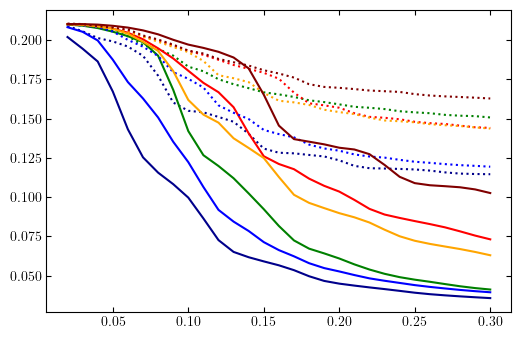

In [77]:
poly_exs = [
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b3', 'b4', 'b5'],
    ['b2', 'b3', 'b4', 'b5'],
    ['a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a3', 'a4', 'b2', 'b3', 'b4', 'b5'],
    [],
]
cps_ex = ['alpha', 'beta', 'YHe', 'tau']
cs = ['darkblue', 'green', 'red', 'blue', 'orange', 'maroon']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')


with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    survey = dfs.desi
    key_svy = survey['short_name']
    for poly_ex, c in zip(poly_exs, cs):
        sns = []
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsp = fm.read_hdf5(fv[key_k]['P']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Pw']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            for fs in [fsp, fspw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        pl = plt.plot(ks, reshape_lines(sns[:,0]), c=c)
        plt.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
#ax.legend()

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

C:\Users\yanlo\Dropbox\galaxy_survey\fisher_matrix.py:72: RuntimeWarning: invalid value encountered in sqrt
  sigmas = np.sqrt(np.diag(np.linalg.inv(sliced.matrix)))


desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

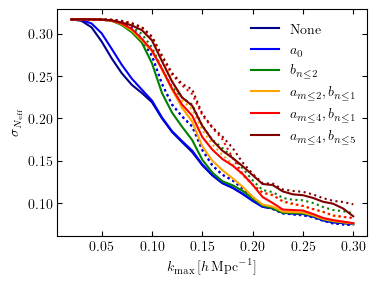

In [84]:
poly_exs = [
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'b5'],
    ['a0', 'a1', 'a2', 'a3', 'a4', 'b3', 'b4', 'b5'],
    ['a3', 'a4', 'b2', 'b3', 'b4', 'b5'],
    ['b2', 'b3', 'b4', 'b5'],
    [],
]
poly_lbs = ['None', '$a_{0}$', '$b_{n\le2}$', '$a_{m\le2},b_{n\le1}$', '$a_{m\le4},b_{n\le1}$', '$a_{m\le4},b_{n\le5}$']
cps_ex = ['alpha', 'beta', ]
cs = ['darkblue', 'blue', 'green', 'orange', 'red', 'maroon']
cmb_fisher = fm.read_hdf5('planck_cmb_fisher_original.hdf5')

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    survey = dfs.desi
    key_svy = survey['short_name']
    for poly_ex, c, lb in zip(poly_exs, cs, poly_lbs):
        sns = []
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsp = fm.read_hdf5(fv[key_k]['B']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            fspw = fm.read_hdf5(fv[key_k]['Bw']).slice(poly_ex, fuzzy_filter=True, exclude=True)
            for fs in [fsp, fspw]:
                sn = fs.merge(cmb_fisher).slice(cps_ex, exclude=True).constraints()[1]['nnu']
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        pl = plt.plot(ks, reshape_lines(sns[:,0]), c=c, label=lb)
        plt.plot(ks, reshape_lines(sns[:,1]), c=pl[0].get_color(), ls=':')
plt.legend(frameon=False)
ax.set_ylabel(r'$\sigma_{N_{\rm eff}}$')
ax.set_xlabel(r'$k_{\rm max}\,[h\,{\rm Mpc}^{-1}]$')

plt.savefig('plots/bispectrum-polynomials.pdf', bbox_inches='tight')

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

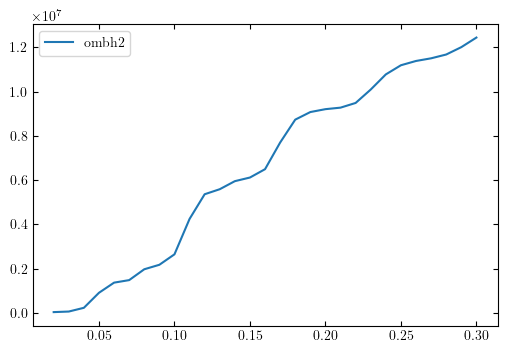

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

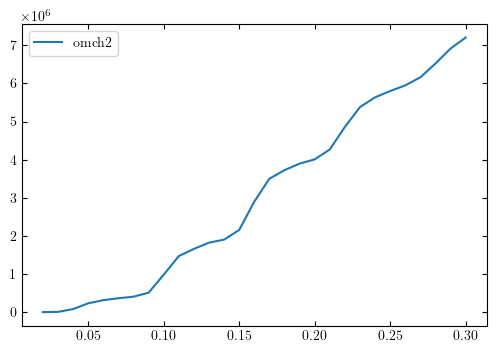

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

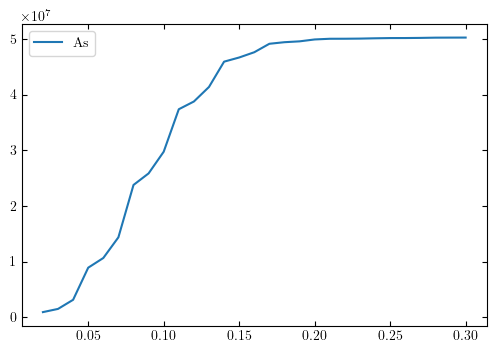

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

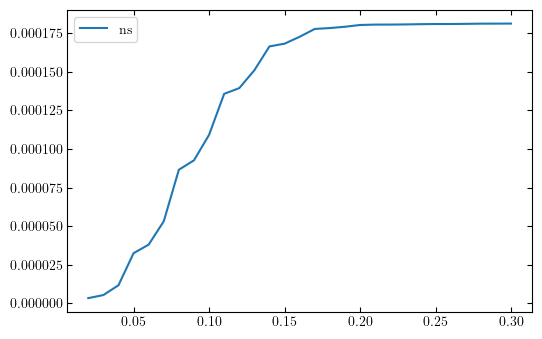

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

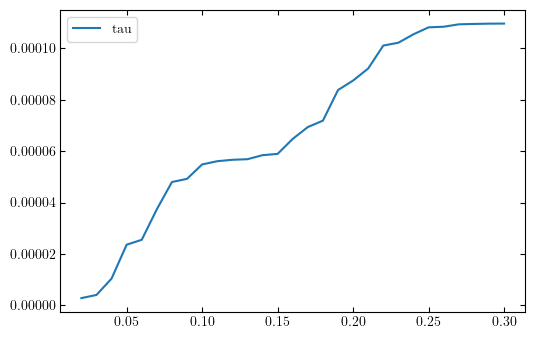

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

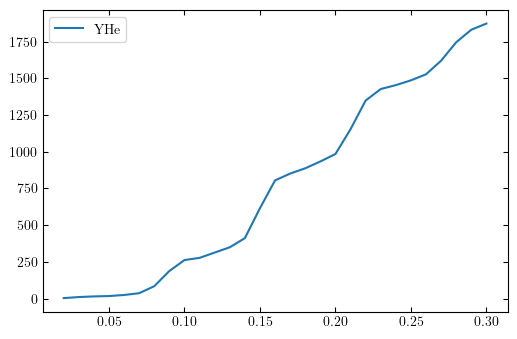

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

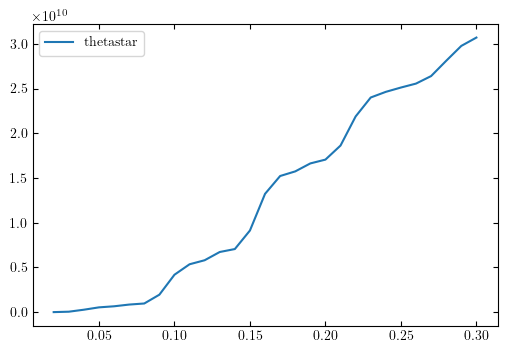

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

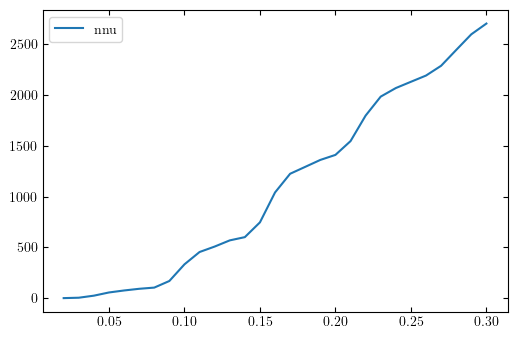

In [41]:
with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    survey = dfs.desi
    key_svy = survey['short_name']
    for el in svy.cosmological_parameters_in_fisher:
        sns = []
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsp = fm.read_hdf5(fv[key_k]['P'])
            fspw = fm.read_hdf5(fv[key_k]['Pw'])
            for fs in [fsp, fspw]:
                sn = fs.element(el)
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        #plt.plot(ks, sns[:,0], label=el)
        plt.plot(ks, sns[:,1], label=el)
        plt.legend()
        plt.show()

desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi desi 

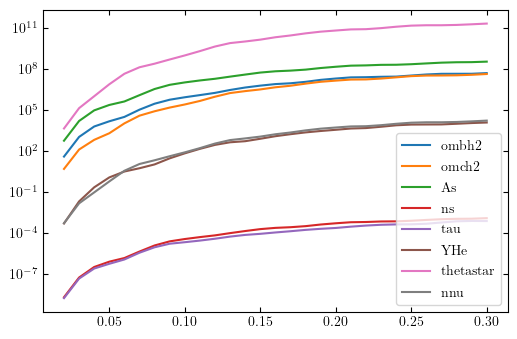

In [36]:
with h5py.File("survey_fisher_matrix_kmax.hdf5", "r") as f:
    survey = dfs.desi
    key_svy = survey['short_name']
    for el in svy.cosmological_parameters_in_fisher:
        sns = []
        for i in range(len(ks)):
            temp = []
            kmax = ks[i]
            key_k = str(i)
            fv = f[key_svy]
            print(key_svy, end=' ')
            fsp = fm.read_hdf5(fv[key_k]['B'])
            fspw = fm.read_hdf5(fv[key_k]['Bw'])
            for fs in [fsp, fspw]:
                sn = fs.element(el)
                temp.append(sn)
            sns.append(temp)
        sns = np.array(sns)
        plt.semilogy(ks, sns[:,1], label=el)
plt.legend()